So we know from Notebook 10 that trying to make it learn one set of logits per batch is good and gets features right.

How can we make the logits consistent over batches?

Will collect the gradients and gumbel selected values after 5 epochs in each mode. The two modes will be the behavior before burn-in and the behavior after mode-in.

Will follow Notebook 10 with slight modifications (described right before). Remember in Notebook 10, we explored behaviors when all the features were real vs when half the features were noise.

In [1]:
import torch


from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F

import numpy as np

import matplotlib.pyplot as plt
#from sklearn.manifold import TSNE

#import math

#import gc

from utils import *

from sklearn.preprocessing import MinMaxScaler

from scipy.stats import pearsonr

import seaborn as sns

In [2]:
torch.manual_seed(0)
np.random.seed(0)

In [3]:
# really good results for vanilla VAE on synthetic data with EPOCHS set to 50, 
# but when running locally set to 10 for reasonable run times
n_epochs = 600
batch_size = 64
lr = 0.0001
b1 = 0.9
b2 = 0.999

In [4]:
cuda = True if torch.cuda.is_available() else False

Tensor = torch.cuda.FloatTensor if cuda else torch.FloatTensor

device = torch.device("cuda:0" if cuda else "cpu")
#device = 'cpu'
print("Device")
print(device)

Device
cuda:0


In [5]:
D = 30
N = 10000
z_size = 8

In [6]:
torch.manual_seed(0)
np.random.seed(0)

latent_data = np.random.normal(loc=0.0, scale=1.0, size=N*z_size).reshape(N, z_size)

data_mapper = nn.Sequential(
    nn.Linear(z_size, 2 * z_size, bias=False),
    nn.Tanh(),
    nn.Linear(2 * z_size, D, bias = True),
    nn.ReLU()
).to(device)

data_mapper.requires_grad_(False)

latent_data = Tensor(latent_data)
latent_data.requires_grad_(False)

actual_data = data_mapper(latent_data)


for i in range(5):
    print(torch.sum(actual_data[i,:] != 0))

tensor(14, device='cuda:0')
tensor(18, device='cuda:0')
tensor(14, device='cuda:0')
tensor(17, device='cuda:0')
tensor(16, device='cuda:0')


add noiise

In [7]:
noise_features = torch.empty(N * D).normal_(mean=0,std=0.01).reshape(N, D).to(device)
noise_features.requires_grad_(False)

tensor([[ 0.0013,  0.0135,  0.0054,  ..., -0.0047,  0.0033, -0.0097],
        [ 0.0080, -0.0057,  0.0010,  ...,  0.0009, -0.0134,  0.0105],
        [-0.0103, -0.0029,  0.0185,  ..., -0.0133, -0.0037,  0.0134],
        ...,
        [ 0.0073, -0.0149, -0.0108,  ..., -0.0047, -0.0137,  0.0070],
        [ 0.0006, -0.0141, -0.0124,  ..., -0.0085,  0.0069, -0.0110],
        [-0.0159,  0.0177, -0.0087,  ..., -0.0076, -0.0009,  0.0078]],
       device='cuda:0')

In [8]:
actual_data = torch.cat([actual_data, noise_features], dim = 1)

In [9]:
actual_data.shape

torch.Size([10000, 60])

In [10]:
actual_data = actual_data.cpu().numpy()
scaler = MinMaxScaler()
actual_data = scaler.fit_transform(actual_data)

actual_data = Tensor(actual_data)

slices = np.random.permutation(np.arange(actual_data.shape[0]))
upto = int(.8 * len(actual_data))

train_data = actual_data[slices[:upto]]
test_data = actual_data[slices[upto:]]

In [11]:
global_t = 4

Example of what worked before
Vanilla Gumbel

In [12]:
vae_gumbel_truncated = VAE_Gumbel(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))

In [13]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)

Train Epoch: 1 [0/8000 (0%)]	Loss: 42.025238
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.364944
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.814362
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.379112
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.789692
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.276009
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.740120
====> Epoch: 1 Average loss: 40.2651
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.672573
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.857533
Train Epoch: 2 [2560/8000 (32%)]	Loss: 37.325977
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.101463
Train Epoch: 2 [5120/8000 (64%)]	Loss: 35.596703
Train Epoch: 2 [6400/8000 (80%)]	Loss: 34.989117
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.360310
====> Epoch: 2 Average loss: 36.4149
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.523701
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.206936
Train Epoch: 3 [2560/8000 (32%)]	Loss: 33.856945
Train Epoch: 3 [3840/8000 (48%)]	Loss: 33.793369
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.988956
Train E

Train Epoch: 22 [6400/8000 (80%)]	Loss: 31.013247
Train Epoch: 22 [7680/8000 (96%)]	Loss: 31.270163
====> Epoch: 22 Average loss: 31.2534
Train Epoch: 23 [0/8000 (0%)]	Loss: 31.400995
Train Epoch: 23 [1280/8000 (16%)]	Loss: 31.041733
Train Epoch: 23 [2560/8000 (32%)]	Loss: 31.345234
Train Epoch: 23 [3840/8000 (48%)]	Loss: 31.320532
Train Epoch: 23 [5120/8000 (64%)]	Loss: 31.026028
Train Epoch: 23 [6400/8000 (80%)]	Loss: 31.138870
Train Epoch: 23 [7680/8000 (96%)]	Loss: 31.540070
====> Epoch: 23 Average loss: 31.1998
Train Epoch: 24 [0/8000 (0%)]	Loss: 31.346783
Train Epoch: 24 [1280/8000 (16%)]	Loss: 31.366404
Train Epoch: 24 [2560/8000 (32%)]	Loss: 31.085634
Train Epoch: 24 [3840/8000 (48%)]	Loss: 31.071608
Train Epoch: 24 [5120/8000 (64%)]	Loss: 31.239252
Train Epoch: 24 [6400/8000 (80%)]	Loss: 30.930275
Train Epoch: 24 [7680/8000 (96%)]	Loss: 30.941076
====> Epoch: 24 Average loss: 31.1411
Train Epoch: 25 [0/8000 (0%)]	Loss: 31.086084
Train Epoch: 25 [1280/8000 (16%)]	Loss: 31.14980

Train Epoch: 44 [1280/8000 (16%)]	Loss: 30.670044
Train Epoch: 44 [2560/8000 (32%)]	Loss: 30.412287
Train Epoch: 44 [3840/8000 (48%)]	Loss: 30.284142
Train Epoch: 44 [5120/8000 (64%)]	Loss: 30.688267
Train Epoch: 44 [6400/8000 (80%)]	Loss: 30.450047
Train Epoch: 44 [7680/8000 (96%)]	Loss: 30.535494
====> Epoch: 44 Average loss: 30.5022
Train Epoch: 45 [0/8000 (0%)]	Loss: 30.533203
Train Epoch: 45 [1280/8000 (16%)]	Loss: 30.846596
Train Epoch: 45 [2560/8000 (32%)]	Loss: 30.508860
Train Epoch: 45 [3840/8000 (48%)]	Loss: 29.904802
Train Epoch: 45 [5120/8000 (64%)]	Loss: 30.310843
Train Epoch: 45 [6400/8000 (80%)]	Loss: 30.303701
Train Epoch: 45 [7680/8000 (96%)]	Loss: 30.523859
====> Epoch: 45 Average loss: 30.4841
Train Epoch: 46 [0/8000 (0%)]	Loss: 30.400795
Train Epoch: 46 [1280/8000 (16%)]	Loss: 30.438272
Train Epoch: 46 [2560/8000 (32%)]	Loss: 30.436558
Train Epoch: 46 [3840/8000 (48%)]	Loss: 30.414251
Train Epoch: 46 [5120/8000 (64%)]	Loss: 30.590418
Train Epoch: 46 [6400/8000 (80%)

Train Epoch: 65 [5120/8000 (64%)]	Loss: 30.314861
Train Epoch: 65 [6400/8000 (80%)]	Loss: 30.275429
Train Epoch: 65 [7680/8000 (96%)]	Loss: 30.515646
====> Epoch: 65 Average loss: 30.2654
Train Epoch: 66 [0/8000 (0%)]	Loss: 30.269190
Train Epoch: 66 [1280/8000 (16%)]	Loss: 30.405798
Train Epoch: 66 [2560/8000 (32%)]	Loss: 30.376183
Train Epoch: 66 [3840/8000 (48%)]	Loss: 30.321278
Train Epoch: 66 [5120/8000 (64%)]	Loss: 30.236647
Train Epoch: 66 [6400/8000 (80%)]	Loss: 30.661760
Train Epoch: 66 [7680/8000 (96%)]	Loss: 30.284760
====> Epoch: 66 Average loss: 30.2637
Train Epoch: 67 [0/8000 (0%)]	Loss: 30.550797
Train Epoch: 67 [1280/8000 (16%)]	Loss: 30.160597
Train Epoch: 67 [2560/8000 (32%)]	Loss: 30.037903
Train Epoch: 67 [3840/8000 (48%)]	Loss: 30.047459
Train Epoch: 67 [5120/8000 (64%)]	Loss: 29.959616
Train Epoch: 67 [6400/8000 (80%)]	Loss: 30.219284
Train Epoch: 67 [7680/8000 (96%)]	Loss: 30.353281
====> Epoch: 67 Average loss: 30.2571
Train Epoch: 68 [0/8000 (0%)]	Loss: 30.20444

Train Epoch: 87 [1280/8000 (16%)]	Loss: 30.178322
Train Epoch: 87 [2560/8000 (32%)]	Loss: 30.091436
Train Epoch: 87 [3840/8000 (48%)]	Loss: 30.255022
Train Epoch: 87 [5120/8000 (64%)]	Loss: 30.174248
Train Epoch: 87 [6400/8000 (80%)]	Loss: 30.241972
Train Epoch: 87 [7680/8000 (96%)]	Loss: 29.892473
====> Epoch: 87 Average loss: 30.1181
Train Epoch: 88 [0/8000 (0%)]	Loss: 29.949902
Train Epoch: 88 [1280/8000 (16%)]	Loss: 30.106182
Train Epoch: 88 [2560/8000 (32%)]	Loss: 30.103258
Train Epoch: 88 [3840/8000 (48%)]	Loss: 29.951073
Train Epoch: 88 [5120/8000 (64%)]	Loss: 30.088888
Train Epoch: 88 [6400/8000 (80%)]	Loss: 29.955593
Train Epoch: 88 [7680/8000 (96%)]	Loss: 29.905472
====> Epoch: 88 Average loss: 30.1153
Train Epoch: 89 [0/8000 (0%)]	Loss: 30.026413
Train Epoch: 89 [1280/8000 (16%)]	Loss: 30.342913
Train Epoch: 89 [2560/8000 (32%)]	Loss: 30.477049
Train Epoch: 89 [3840/8000 (48%)]	Loss: 29.976637
Train Epoch: 89 [5120/8000 (64%)]	Loss: 30.036428
Train Epoch: 89 [6400/8000 (80%)

Train Epoch: 108 [3840/8000 (48%)]	Loss: 30.187504
Train Epoch: 108 [5120/8000 (64%)]	Loss: 30.084991
Train Epoch: 108 [6400/8000 (80%)]	Loss: 29.825407
Train Epoch: 108 [7680/8000 (96%)]	Loss: 30.185699
====> Epoch: 108 Average loss: 30.0199
Train Epoch: 109 [0/8000 (0%)]	Loss: 30.047487
Train Epoch: 109 [1280/8000 (16%)]	Loss: 30.071058
Train Epoch: 109 [2560/8000 (32%)]	Loss: 30.151487
Train Epoch: 109 [3840/8000 (48%)]	Loss: 29.893038
Train Epoch: 109 [5120/8000 (64%)]	Loss: 30.048811
Train Epoch: 109 [6400/8000 (80%)]	Loss: 30.199945
Train Epoch: 109 [7680/8000 (96%)]	Loss: 29.811132
====> Epoch: 109 Average loss: 30.0074
Train Epoch: 110 [0/8000 (0%)]	Loss: 30.155910
Train Epoch: 110 [1280/8000 (16%)]	Loss: 29.979328
Train Epoch: 110 [2560/8000 (32%)]	Loss: 29.907679
Train Epoch: 110 [3840/8000 (48%)]	Loss: 30.225660
Train Epoch: 110 [5120/8000 (64%)]	Loss: 29.976118
Train Epoch: 110 [6400/8000 (80%)]	Loss: 30.185572
Train Epoch: 110 [7680/8000 (96%)]	Loss: 30.027384
====> Epoch:

Train Epoch: 129 [3840/8000 (48%)]	Loss: 29.985014
Train Epoch: 129 [5120/8000 (64%)]	Loss: 29.919464
Train Epoch: 129 [6400/8000 (80%)]	Loss: 30.219847
Train Epoch: 129 [7680/8000 (96%)]	Loss: 29.820976
====> Epoch: 129 Average loss: 29.9723
Train Epoch: 130 [0/8000 (0%)]	Loss: 30.122189
Train Epoch: 130 [1280/8000 (16%)]	Loss: 30.201637
Train Epoch: 130 [2560/8000 (32%)]	Loss: 29.909433
Train Epoch: 130 [3840/8000 (48%)]	Loss: 30.099302
Train Epoch: 130 [5120/8000 (64%)]	Loss: 30.374634
Train Epoch: 130 [6400/8000 (80%)]	Loss: 29.855406
Train Epoch: 130 [7680/8000 (96%)]	Loss: 30.114468
====> Epoch: 130 Average loss: 29.9691
Train Epoch: 131 [0/8000 (0%)]	Loss: 30.045776
Train Epoch: 131 [1280/8000 (16%)]	Loss: 29.958166
Train Epoch: 131 [2560/8000 (32%)]	Loss: 29.941027
Train Epoch: 131 [3840/8000 (48%)]	Loss: 29.994801
Train Epoch: 131 [5120/8000 (64%)]	Loss: 29.670864
Train Epoch: 131 [6400/8000 (80%)]	Loss: 30.106087
Train Epoch: 131 [7680/8000 (96%)]	Loss: 30.091990
====> Epoch:

Train Epoch: 150 [3840/8000 (48%)]	Loss: 29.749752
Train Epoch: 150 [5120/8000 (64%)]	Loss: 29.954885
Train Epoch: 150 [6400/8000 (80%)]	Loss: 30.014194
Train Epoch: 150 [7680/8000 (96%)]	Loss: 29.903946
====> Epoch: 150 Average loss: 29.9383
Train Epoch: 151 [0/8000 (0%)]	Loss: 29.989189
Train Epoch: 151 [1280/8000 (16%)]	Loss: 29.882895
Train Epoch: 151 [2560/8000 (32%)]	Loss: 30.154171
Train Epoch: 151 [3840/8000 (48%)]	Loss: 30.058058
Train Epoch: 151 [5120/8000 (64%)]	Loss: 29.770472
Train Epoch: 151 [6400/8000 (80%)]	Loss: 30.269991
Train Epoch: 151 [7680/8000 (96%)]	Loss: 29.704365
====> Epoch: 151 Average loss: 29.9426
Train Epoch: 152 [0/8000 (0%)]	Loss: 29.933056
Train Epoch: 152 [1280/8000 (16%)]	Loss: 30.089949
Train Epoch: 152 [2560/8000 (32%)]	Loss: 30.051254
Train Epoch: 152 [3840/8000 (48%)]	Loss: 29.807831
Train Epoch: 152 [5120/8000 (64%)]	Loss: 29.812853
Train Epoch: 152 [6400/8000 (80%)]	Loss: 29.733080
Train Epoch: 152 [7680/8000 (96%)]	Loss: 29.984697
====> Epoch:

Train Epoch: 171 [3840/8000 (48%)]	Loss: 29.825205
Train Epoch: 171 [5120/8000 (64%)]	Loss: 29.897509
Train Epoch: 171 [6400/8000 (80%)]	Loss: 29.795473
Train Epoch: 171 [7680/8000 (96%)]	Loss: 29.633804
====> Epoch: 171 Average loss: 29.9267
Train Epoch: 172 [0/8000 (0%)]	Loss: 30.154598
Train Epoch: 172 [1280/8000 (16%)]	Loss: 29.911493
Train Epoch: 172 [2560/8000 (32%)]	Loss: 30.012550
Train Epoch: 172 [3840/8000 (48%)]	Loss: 29.933237
Train Epoch: 172 [5120/8000 (64%)]	Loss: 29.937500
Train Epoch: 172 [6400/8000 (80%)]	Loss: 29.816090
Train Epoch: 172 [7680/8000 (96%)]	Loss: 29.972908
====> Epoch: 172 Average loss: 29.9230
Train Epoch: 173 [0/8000 (0%)]	Loss: 29.951574
Train Epoch: 173 [1280/8000 (16%)]	Loss: 30.172197
Train Epoch: 173 [2560/8000 (32%)]	Loss: 29.894226
Train Epoch: 173 [3840/8000 (48%)]	Loss: 30.058176
Train Epoch: 173 [5120/8000 (64%)]	Loss: 30.124512
Train Epoch: 173 [6400/8000 (80%)]	Loss: 29.841183
Train Epoch: 173 [7680/8000 (96%)]	Loss: 29.712990
====> Epoch:

Train Epoch: 192 [3840/8000 (48%)]	Loss: 30.222816
Train Epoch: 192 [5120/8000 (64%)]	Loss: 30.060699
Train Epoch: 192 [6400/8000 (80%)]	Loss: 30.104168
Train Epoch: 192 [7680/8000 (96%)]	Loss: 29.902025
====> Epoch: 192 Average loss: 29.9089
Train Epoch: 193 [0/8000 (0%)]	Loss: 29.930532
Train Epoch: 193 [1280/8000 (16%)]	Loss: 29.928764
Train Epoch: 193 [2560/8000 (32%)]	Loss: 29.963558
Train Epoch: 193 [3840/8000 (48%)]	Loss: 30.271313
Train Epoch: 193 [5120/8000 (64%)]	Loss: 29.973206
Train Epoch: 193 [6400/8000 (80%)]	Loss: 29.941650
Train Epoch: 193 [7680/8000 (96%)]	Loss: 29.890982
====> Epoch: 193 Average loss: 29.9097
Train Epoch: 194 [0/8000 (0%)]	Loss: 30.111902
Train Epoch: 194 [1280/8000 (16%)]	Loss: 29.820795
Train Epoch: 194 [2560/8000 (32%)]	Loss: 29.893639
Train Epoch: 194 [3840/8000 (48%)]	Loss: 29.748861
Train Epoch: 194 [5120/8000 (64%)]	Loss: 29.962934
Train Epoch: 194 [6400/8000 (80%)]	Loss: 30.054029
Train Epoch: 194 [7680/8000 (96%)]	Loss: 30.138664
====> Epoch:

Train Epoch: 213 [3840/8000 (48%)]	Loss: 30.119467
Train Epoch: 213 [5120/8000 (64%)]	Loss: 29.941584
Train Epoch: 213 [6400/8000 (80%)]	Loss: 29.797318
Train Epoch: 213 [7680/8000 (96%)]	Loss: 29.949215
====> Epoch: 213 Average loss: 29.8991
Train Epoch: 214 [0/8000 (0%)]	Loss: 29.839544
Train Epoch: 214 [1280/8000 (16%)]	Loss: 29.883739
Train Epoch: 214 [2560/8000 (32%)]	Loss: 29.887419
Train Epoch: 214 [3840/8000 (48%)]	Loss: 29.690292
Train Epoch: 214 [5120/8000 (64%)]	Loss: 30.246571
Train Epoch: 214 [6400/8000 (80%)]	Loss: 29.978983
Train Epoch: 214 [7680/8000 (96%)]	Loss: 29.981712
====> Epoch: 214 Average loss: 29.9021
Train Epoch: 215 [0/8000 (0%)]	Loss: 29.795774
Train Epoch: 215 [1280/8000 (16%)]	Loss: 30.158306
Train Epoch: 215 [2560/8000 (32%)]	Loss: 29.867483
Train Epoch: 215 [3840/8000 (48%)]	Loss: 29.992905
Train Epoch: 215 [5120/8000 (64%)]	Loss: 29.758713
Train Epoch: 215 [6400/8000 (80%)]	Loss: 30.128817
Train Epoch: 215 [7680/8000 (96%)]	Loss: 29.955023
====> Epoch:

Train Epoch: 234 [3840/8000 (48%)]	Loss: 30.038889
Train Epoch: 234 [5120/8000 (64%)]	Loss: 29.957014
Train Epoch: 234 [6400/8000 (80%)]	Loss: 29.933414
Train Epoch: 234 [7680/8000 (96%)]	Loss: 29.695461
====> Epoch: 234 Average loss: 29.8886
Train Epoch: 235 [0/8000 (0%)]	Loss: 29.780043
Train Epoch: 235 [1280/8000 (16%)]	Loss: 30.145016
Train Epoch: 235 [2560/8000 (32%)]	Loss: 29.855495
Train Epoch: 235 [3840/8000 (48%)]	Loss: 29.794701
Train Epoch: 235 [5120/8000 (64%)]	Loss: 29.772831
Train Epoch: 235 [6400/8000 (80%)]	Loss: 29.978886
Train Epoch: 235 [7680/8000 (96%)]	Loss: 29.753181
====> Epoch: 235 Average loss: 29.8867
Train Epoch: 236 [0/8000 (0%)]	Loss: 29.773815
Train Epoch: 236 [1280/8000 (16%)]	Loss: 29.933281
Train Epoch: 236 [2560/8000 (32%)]	Loss: 29.645767
Train Epoch: 236 [3840/8000 (48%)]	Loss: 29.926254
Train Epoch: 236 [5120/8000 (64%)]	Loss: 29.930956
Train Epoch: 236 [6400/8000 (80%)]	Loss: 29.873896
Train Epoch: 236 [7680/8000 (96%)]	Loss: 30.033524
====> Epoch:

Train Epoch: 255 [3840/8000 (48%)]	Loss: 29.914280
Train Epoch: 255 [5120/8000 (64%)]	Loss: 29.604420
Train Epoch: 255 [6400/8000 (80%)]	Loss: 30.064692
Train Epoch: 255 [7680/8000 (96%)]	Loss: 29.801399
====> Epoch: 255 Average loss: 29.8879
Train Epoch: 256 [0/8000 (0%)]	Loss: 30.018766
Train Epoch: 256 [1280/8000 (16%)]	Loss: 29.783800
Train Epoch: 256 [2560/8000 (32%)]	Loss: 29.791483
Train Epoch: 256 [3840/8000 (48%)]	Loss: 29.889681
Train Epoch: 256 [5120/8000 (64%)]	Loss: 29.727346
Train Epoch: 256 [6400/8000 (80%)]	Loss: 29.899672
Train Epoch: 256 [7680/8000 (96%)]	Loss: 29.867802
====> Epoch: 256 Average loss: 29.8831
Train Epoch: 257 [0/8000 (0%)]	Loss: 29.792427
Train Epoch: 257 [1280/8000 (16%)]	Loss: 30.205387
Train Epoch: 257 [2560/8000 (32%)]	Loss: 29.972410
Train Epoch: 257 [3840/8000 (48%)]	Loss: 29.745226
Train Epoch: 257 [5120/8000 (64%)]	Loss: 29.816378
Train Epoch: 257 [6400/8000 (80%)]	Loss: 30.031929
Train Epoch: 257 [7680/8000 (96%)]	Loss: 29.761208
====> Epoch:

Train Epoch: 276 [3840/8000 (48%)]	Loss: 29.628841
Train Epoch: 276 [5120/8000 (64%)]	Loss: 30.032913
Train Epoch: 276 [6400/8000 (80%)]	Loss: 29.950617
Train Epoch: 276 [7680/8000 (96%)]	Loss: 29.897568
====> Epoch: 276 Average loss: 29.8897
Train Epoch: 277 [0/8000 (0%)]	Loss: 30.019409
Train Epoch: 277 [1280/8000 (16%)]	Loss: 29.637428
Train Epoch: 277 [2560/8000 (32%)]	Loss: 29.856844
Train Epoch: 277 [3840/8000 (48%)]	Loss: 29.778315
Train Epoch: 277 [5120/8000 (64%)]	Loss: 29.973459
Train Epoch: 277 [6400/8000 (80%)]	Loss: 29.765484
Train Epoch: 277 [7680/8000 (96%)]	Loss: 30.126080
====> Epoch: 277 Average loss: 29.8865
Train Epoch: 278 [0/8000 (0%)]	Loss: 29.856239
Train Epoch: 278 [1280/8000 (16%)]	Loss: 30.042213
Train Epoch: 278 [2560/8000 (32%)]	Loss: 29.932316
Train Epoch: 278 [3840/8000 (48%)]	Loss: 29.884962
Train Epoch: 278 [5120/8000 (64%)]	Loss: 29.660421
Train Epoch: 278 [6400/8000 (80%)]	Loss: 30.074553
Train Epoch: 278 [7680/8000 (96%)]	Loss: 30.105274
====> Epoch:

Train Epoch: 297 [3840/8000 (48%)]	Loss: 29.617807
Train Epoch: 297 [5120/8000 (64%)]	Loss: 29.947329
Train Epoch: 297 [6400/8000 (80%)]	Loss: 29.799597
Train Epoch: 297 [7680/8000 (96%)]	Loss: 29.685078
====> Epoch: 297 Average loss: 29.8841
Train Epoch: 298 [0/8000 (0%)]	Loss: 30.049799
Train Epoch: 298 [1280/8000 (16%)]	Loss: 29.784077
Train Epoch: 298 [2560/8000 (32%)]	Loss: 29.923767
Train Epoch: 298 [3840/8000 (48%)]	Loss: 29.788635
Train Epoch: 298 [5120/8000 (64%)]	Loss: 29.831011
Train Epoch: 298 [6400/8000 (80%)]	Loss: 29.843224
Train Epoch: 298 [7680/8000 (96%)]	Loss: 29.931044
====> Epoch: 298 Average loss: 29.8960
Train Epoch: 299 [0/8000 (0%)]	Loss: 29.784607
Train Epoch: 299 [1280/8000 (16%)]	Loss: 30.015869
Train Epoch: 299 [2560/8000 (32%)]	Loss: 30.110130
Train Epoch: 299 [3840/8000 (48%)]	Loss: 30.118687
Train Epoch: 299 [5120/8000 (64%)]	Loss: 29.648788
Train Epoch: 299 [6400/8000 (80%)]	Loss: 29.750799
Train Epoch: 299 [7680/8000 (96%)]	Loss: 29.804449
====> Epoch:

Train Epoch: 318 [3840/8000 (48%)]	Loss: 29.749100
Train Epoch: 318 [5120/8000 (64%)]	Loss: 30.035702
Train Epoch: 318 [6400/8000 (80%)]	Loss: 29.961561
Train Epoch: 318 [7680/8000 (96%)]	Loss: 29.569353
====> Epoch: 318 Average loss: 29.8831
Train Epoch: 319 [0/8000 (0%)]	Loss: 29.704031
Train Epoch: 319 [1280/8000 (16%)]	Loss: 29.798531
Train Epoch: 319 [2560/8000 (32%)]	Loss: 29.845575
Train Epoch: 319 [3840/8000 (48%)]	Loss: 29.872572
Train Epoch: 319 [5120/8000 (64%)]	Loss: 29.871683
Train Epoch: 319 [6400/8000 (80%)]	Loss: 30.076948
Train Epoch: 319 [7680/8000 (96%)]	Loss: 30.090963
====> Epoch: 319 Average loss: 29.8862
Train Epoch: 320 [0/8000 (0%)]	Loss: 29.693029
Train Epoch: 320 [1280/8000 (16%)]	Loss: 29.920881
Train Epoch: 320 [2560/8000 (32%)]	Loss: 29.895258
Train Epoch: 320 [3840/8000 (48%)]	Loss: 29.647491
Train Epoch: 320 [5120/8000 (64%)]	Loss: 29.681486
Train Epoch: 320 [6400/8000 (80%)]	Loss: 30.012787
Train Epoch: 320 [7680/8000 (96%)]	Loss: 30.116014
====> Epoch:

Train Epoch: 339 [3840/8000 (48%)]	Loss: 29.633453
Train Epoch: 339 [5120/8000 (64%)]	Loss: 29.920126
Train Epoch: 339 [6400/8000 (80%)]	Loss: 29.743887
Train Epoch: 339 [7680/8000 (96%)]	Loss: 30.091244
====> Epoch: 339 Average loss: 29.8819
Train Epoch: 340 [0/8000 (0%)]	Loss: 29.931381
Train Epoch: 340 [1280/8000 (16%)]	Loss: 29.813457
Train Epoch: 340 [2560/8000 (32%)]	Loss: 29.803770
Train Epoch: 340 [3840/8000 (48%)]	Loss: 29.894396
Train Epoch: 340 [5120/8000 (64%)]	Loss: 29.930799
Train Epoch: 340 [6400/8000 (80%)]	Loss: 29.988342
Train Epoch: 340 [7680/8000 (96%)]	Loss: 29.821905
====> Epoch: 340 Average loss: 29.8854
Train Epoch: 341 [0/8000 (0%)]	Loss: 30.001682
Train Epoch: 341 [1280/8000 (16%)]	Loss: 29.808956
Train Epoch: 341 [2560/8000 (32%)]	Loss: 29.972176
Train Epoch: 341 [3840/8000 (48%)]	Loss: 30.125950
Train Epoch: 341 [5120/8000 (64%)]	Loss: 29.749815
Train Epoch: 341 [6400/8000 (80%)]	Loss: 29.792273
Train Epoch: 341 [7680/8000 (96%)]	Loss: 29.971445
====> Epoch:

Train Epoch: 360 [3840/8000 (48%)]	Loss: 30.015242
Train Epoch: 360 [5120/8000 (64%)]	Loss: 29.979177
Train Epoch: 360 [6400/8000 (80%)]	Loss: 30.068678
Train Epoch: 360 [7680/8000 (96%)]	Loss: 29.693998
====> Epoch: 360 Average loss: 29.8886
Train Epoch: 361 [0/8000 (0%)]	Loss: 30.072481
Train Epoch: 361 [1280/8000 (16%)]	Loss: 29.890997
Train Epoch: 361 [2560/8000 (32%)]	Loss: 29.510504
Train Epoch: 361 [3840/8000 (48%)]	Loss: 29.779207
Train Epoch: 361 [5120/8000 (64%)]	Loss: 29.899338
Train Epoch: 361 [6400/8000 (80%)]	Loss: 29.576227
Train Epoch: 361 [7680/8000 (96%)]	Loss: 29.996140
====> Epoch: 361 Average loss: 29.8823
Train Epoch: 362 [0/8000 (0%)]	Loss: 29.994949
Train Epoch: 362 [1280/8000 (16%)]	Loss: 29.940674
Train Epoch: 362 [2560/8000 (32%)]	Loss: 29.892300
Train Epoch: 362 [3840/8000 (48%)]	Loss: 29.955666
Train Epoch: 362 [5120/8000 (64%)]	Loss: 29.678120
Train Epoch: 362 [6400/8000 (80%)]	Loss: 30.019081
Train Epoch: 362 [7680/8000 (96%)]	Loss: 29.933397
====> Epoch:

Train Epoch: 381 [3840/8000 (48%)]	Loss: 29.971119
Train Epoch: 381 [5120/8000 (64%)]	Loss: 29.741529
Train Epoch: 381 [6400/8000 (80%)]	Loss: 30.033043
Train Epoch: 381 [7680/8000 (96%)]	Loss: 29.689795
====> Epoch: 381 Average loss: 29.8818
Train Epoch: 382 [0/8000 (0%)]	Loss: 29.957310
Train Epoch: 382 [1280/8000 (16%)]	Loss: 29.892405
Train Epoch: 382 [2560/8000 (32%)]	Loss: 29.728783
Train Epoch: 382 [3840/8000 (48%)]	Loss: 29.906771
Train Epoch: 382 [5120/8000 (64%)]	Loss: 29.694315
Train Epoch: 382 [6400/8000 (80%)]	Loss: 29.846998
Train Epoch: 382 [7680/8000 (96%)]	Loss: 29.858217
====> Epoch: 382 Average loss: 29.8813
Train Epoch: 383 [0/8000 (0%)]	Loss: 29.901493
Train Epoch: 383 [1280/8000 (16%)]	Loss: 29.741205
Train Epoch: 383 [2560/8000 (32%)]	Loss: 30.037868
Train Epoch: 383 [3840/8000 (48%)]	Loss: 29.870022
Train Epoch: 383 [5120/8000 (64%)]	Loss: 29.830746
Train Epoch: 383 [6400/8000 (80%)]	Loss: 30.024740
Train Epoch: 383 [7680/8000 (96%)]	Loss: 29.799429
====> Epoch:

Train Epoch: 402 [3840/8000 (48%)]	Loss: 30.138117
Train Epoch: 402 [5120/8000 (64%)]	Loss: 30.035879
Train Epoch: 402 [6400/8000 (80%)]	Loss: 30.024965
Train Epoch: 402 [7680/8000 (96%)]	Loss: 30.232817
====> Epoch: 402 Average loss: 29.8806
Train Epoch: 403 [0/8000 (0%)]	Loss: 29.568306
Train Epoch: 403 [1280/8000 (16%)]	Loss: 29.724127
Train Epoch: 403 [2560/8000 (32%)]	Loss: 30.048752
Train Epoch: 403 [3840/8000 (48%)]	Loss: 29.594883
Train Epoch: 403 [5120/8000 (64%)]	Loss: 30.108351
Train Epoch: 403 [6400/8000 (80%)]	Loss: 29.833328
Train Epoch: 403 [7680/8000 (96%)]	Loss: 29.892607
====> Epoch: 403 Average loss: 29.8666
Train Epoch: 404 [0/8000 (0%)]	Loss: 30.031109
Train Epoch: 404 [1280/8000 (16%)]	Loss: 29.812700
Train Epoch: 404 [2560/8000 (32%)]	Loss: 29.909380
Train Epoch: 404 [3840/8000 (48%)]	Loss: 29.995502
Train Epoch: 404 [5120/8000 (64%)]	Loss: 30.003708
Train Epoch: 404 [6400/8000 (80%)]	Loss: 29.707998
Train Epoch: 404 [7680/8000 (96%)]	Loss: 29.921495
====> Epoch:

Train Epoch: 423 [3840/8000 (48%)]	Loss: 29.759045
Train Epoch: 423 [5120/8000 (64%)]	Loss: 29.714851
Train Epoch: 423 [6400/8000 (80%)]	Loss: 29.889101
Train Epoch: 423 [7680/8000 (96%)]	Loss: 29.740225
====> Epoch: 423 Average loss: 29.8758
Train Epoch: 424 [0/8000 (0%)]	Loss: 30.182491
Train Epoch: 424 [1280/8000 (16%)]	Loss: 30.138966
Train Epoch: 424 [2560/8000 (32%)]	Loss: 29.862980
Train Epoch: 424 [3840/8000 (48%)]	Loss: 30.202427
Train Epoch: 424 [5120/8000 (64%)]	Loss: 30.086912
Train Epoch: 424 [6400/8000 (80%)]	Loss: 29.746981
Train Epoch: 424 [7680/8000 (96%)]	Loss: 29.691172
====> Epoch: 424 Average loss: 29.8777
Train Epoch: 425 [0/8000 (0%)]	Loss: 30.161909
Train Epoch: 425 [1280/8000 (16%)]	Loss: 29.902170
Train Epoch: 425 [2560/8000 (32%)]	Loss: 29.899593
Train Epoch: 425 [3840/8000 (48%)]	Loss: 29.970158
Train Epoch: 425 [5120/8000 (64%)]	Loss: 29.858995
Train Epoch: 425 [6400/8000 (80%)]	Loss: 30.073761
Train Epoch: 425 [7680/8000 (96%)]	Loss: 29.820612
====> Epoch:

Train Epoch: 444 [3840/8000 (48%)]	Loss: 29.712931
Train Epoch: 444 [5120/8000 (64%)]	Loss: 30.030609
Train Epoch: 444 [6400/8000 (80%)]	Loss: 30.041574
Train Epoch: 444 [7680/8000 (96%)]	Loss: 29.686581
====> Epoch: 444 Average loss: 29.8602
Train Epoch: 445 [0/8000 (0%)]	Loss: 29.969954
Train Epoch: 445 [1280/8000 (16%)]	Loss: 29.878975
Train Epoch: 445 [2560/8000 (32%)]	Loss: 29.757170
Train Epoch: 445 [3840/8000 (48%)]	Loss: 29.802805
Train Epoch: 445 [5120/8000 (64%)]	Loss: 29.568787
Train Epoch: 445 [6400/8000 (80%)]	Loss: 29.884750
Train Epoch: 445 [7680/8000 (96%)]	Loss: 29.940552
====> Epoch: 445 Average loss: 29.8574
Train Epoch: 446 [0/8000 (0%)]	Loss: 29.848927
Train Epoch: 446 [1280/8000 (16%)]	Loss: 30.029221
Train Epoch: 446 [2560/8000 (32%)]	Loss: 29.930370
Train Epoch: 446 [3840/8000 (48%)]	Loss: 29.721516
Train Epoch: 446 [5120/8000 (64%)]	Loss: 29.864086
Train Epoch: 446 [6400/8000 (80%)]	Loss: 29.681242
Train Epoch: 446 [7680/8000 (96%)]	Loss: 30.092154
====> Epoch:

Train Epoch: 465 [3840/8000 (48%)]	Loss: 29.932259
Train Epoch: 465 [5120/8000 (64%)]	Loss: 30.039270
Train Epoch: 465 [6400/8000 (80%)]	Loss: 29.829027
Train Epoch: 465 [7680/8000 (96%)]	Loss: 29.764664
====> Epoch: 465 Average loss: 29.8395
Train Epoch: 466 [0/8000 (0%)]	Loss: 30.089323
Train Epoch: 466 [1280/8000 (16%)]	Loss: 29.695213
Train Epoch: 466 [2560/8000 (32%)]	Loss: 29.484402
Train Epoch: 466 [3840/8000 (48%)]	Loss: 30.078396
Train Epoch: 466 [5120/8000 (64%)]	Loss: 29.850939
Train Epoch: 466 [6400/8000 (80%)]	Loss: 29.693317
Train Epoch: 466 [7680/8000 (96%)]	Loss: 29.941410
====> Epoch: 466 Average loss: 29.8312
Train Epoch: 467 [0/8000 (0%)]	Loss: 29.797054
Train Epoch: 467 [1280/8000 (16%)]	Loss: 30.224150
Train Epoch: 467 [2560/8000 (32%)]	Loss: 29.911831
Train Epoch: 467 [3840/8000 (48%)]	Loss: 29.938236
Train Epoch: 467 [5120/8000 (64%)]	Loss: 29.817513
Train Epoch: 467 [6400/8000 (80%)]	Loss: 29.384737
Train Epoch: 467 [7680/8000 (96%)]	Loss: 29.541088
====> Epoch:

Train Epoch: 486 [3840/8000 (48%)]	Loss: 29.901243
Train Epoch: 486 [5120/8000 (64%)]	Loss: 30.003246
Train Epoch: 486 [6400/8000 (80%)]	Loss: 29.956362
Train Epoch: 486 [7680/8000 (96%)]	Loss: 29.830139
====> Epoch: 486 Average loss: 29.8308
Train Epoch: 487 [0/8000 (0%)]	Loss: 29.780581
Train Epoch: 487 [1280/8000 (16%)]	Loss: 29.872816
Train Epoch: 487 [2560/8000 (32%)]	Loss: 29.804417
Train Epoch: 487 [3840/8000 (48%)]	Loss: 29.659899
Train Epoch: 487 [5120/8000 (64%)]	Loss: 29.847864
Train Epoch: 487 [6400/8000 (80%)]	Loss: 29.612928
Train Epoch: 487 [7680/8000 (96%)]	Loss: 29.864241
====> Epoch: 487 Average loss: 29.8337
Train Epoch: 488 [0/8000 (0%)]	Loss: 29.548439
Train Epoch: 488 [1280/8000 (16%)]	Loss: 29.751884
Train Epoch: 488 [2560/8000 (32%)]	Loss: 29.731762
Train Epoch: 488 [3840/8000 (48%)]	Loss: 30.002707
Train Epoch: 488 [5120/8000 (64%)]	Loss: 29.586905
Train Epoch: 488 [6400/8000 (80%)]	Loss: 29.906916
Train Epoch: 488 [7680/8000 (96%)]	Loss: 29.697769
====> Epoch:

Train Epoch: 507 [3840/8000 (48%)]	Loss: 29.601776
Train Epoch: 507 [5120/8000 (64%)]	Loss: 29.643343
Train Epoch: 507 [6400/8000 (80%)]	Loss: 29.625200
Train Epoch: 507 [7680/8000 (96%)]	Loss: 29.974998
====> Epoch: 507 Average loss: 29.8198
Train Epoch: 508 [0/8000 (0%)]	Loss: 29.749811
Train Epoch: 508 [1280/8000 (16%)]	Loss: 29.894016
Train Epoch: 508 [2560/8000 (32%)]	Loss: 29.643345
Train Epoch: 508 [3840/8000 (48%)]	Loss: 29.773540
Train Epoch: 508 [5120/8000 (64%)]	Loss: 29.856907
Train Epoch: 508 [6400/8000 (80%)]	Loss: 30.021587
Train Epoch: 508 [7680/8000 (96%)]	Loss: 29.863167
====> Epoch: 508 Average loss: 29.8230
Train Epoch: 509 [0/8000 (0%)]	Loss: 29.739193
Train Epoch: 509 [1280/8000 (16%)]	Loss: 29.876884
Train Epoch: 509 [2560/8000 (32%)]	Loss: 30.012199
Train Epoch: 509 [3840/8000 (48%)]	Loss: 29.507177
Train Epoch: 509 [5120/8000 (64%)]	Loss: 29.777090
Train Epoch: 509 [6400/8000 (80%)]	Loss: 29.862701
Train Epoch: 509 [7680/8000 (96%)]	Loss: 29.891886
====> Epoch:

Train Epoch: 528 [3840/8000 (48%)]	Loss: 29.952415
Train Epoch: 528 [5120/8000 (64%)]	Loss: 29.414206
Train Epoch: 528 [6400/8000 (80%)]	Loss: 29.708725
Train Epoch: 528 [7680/8000 (96%)]	Loss: 29.780281
====> Epoch: 528 Average loss: 29.8062
Train Epoch: 529 [0/8000 (0%)]	Loss: 29.510487
Train Epoch: 529 [1280/8000 (16%)]	Loss: 29.805365
Train Epoch: 529 [2560/8000 (32%)]	Loss: 29.697664
Train Epoch: 529 [3840/8000 (48%)]	Loss: 29.815443
Train Epoch: 529 [5120/8000 (64%)]	Loss: 29.610271
Train Epoch: 529 [6400/8000 (80%)]	Loss: 29.925415
Train Epoch: 529 [7680/8000 (96%)]	Loss: 29.703550
====> Epoch: 529 Average loss: 29.8033
Train Epoch: 530 [0/8000 (0%)]	Loss: 29.822939
Train Epoch: 530 [1280/8000 (16%)]	Loss: 29.735056
Train Epoch: 530 [2560/8000 (32%)]	Loss: 29.947550
Train Epoch: 530 [3840/8000 (48%)]	Loss: 29.584866
Train Epoch: 530 [5120/8000 (64%)]	Loss: 29.640837
Train Epoch: 530 [6400/8000 (80%)]	Loss: 29.828270
Train Epoch: 530 [7680/8000 (96%)]	Loss: 29.796869
====> Epoch:

Train Epoch: 549 [3840/8000 (48%)]	Loss: 29.936510
Train Epoch: 549 [5120/8000 (64%)]	Loss: 29.795532
Train Epoch: 549 [6400/8000 (80%)]	Loss: 29.810223
Train Epoch: 549 [7680/8000 (96%)]	Loss: 29.893778
====> Epoch: 549 Average loss: 29.7953
Train Epoch: 550 [0/8000 (0%)]	Loss: 29.712572
Train Epoch: 550 [1280/8000 (16%)]	Loss: 29.824915
Train Epoch: 550 [2560/8000 (32%)]	Loss: 29.776793
Train Epoch: 550 [3840/8000 (48%)]	Loss: 29.731041
Train Epoch: 550 [5120/8000 (64%)]	Loss: 29.899935
Train Epoch: 550 [6400/8000 (80%)]	Loss: 29.742662
Train Epoch: 550 [7680/8000 (96%)]	Loss: 29.778988
====> Epoch: 550 Average loss: 29.7965
Train Epoch: 551 [0/8000 (0%)]	Loss: 29.713850
Train Epoch: 551 [1280/8000 (16%)]	Loss: 29.810085
Train Epoch: 551 [2560/8000 (32%)]	Loss: 29.668133
Train Epoch: 551 [3840/8000 (48%)]	Loss: 29.661205
Train Epoch: 551 [5120/8000 (64%)]	Loss: 29.919502
Train Epoch: 551 [6400/8000 (80%)]	Loss: 29.809557
Train Epoch: 551 [7680/8000 (96%)]	Loss: 29.849710
====> Epoch:

Train Epoch: 570 [3840/8000 (48%)]	Loss: 29.756998
Train Epoch: 570 [5120/8000 (64%)]	Loss: 29.924185
Train Epoch: 570 [6400/8000 (80%)]	Loss: 29.552128
Train Epoch: 570 [7680/8000 (96%)]	Loss: 29.937946
====> Epoch: 570 Average loss: 29.7797
Train Epoch: 571 [0/8000 (0%)]	Loss: 29.951065
Train Epoch: 571 [1280/8000 (16%)]	Loss: 29.929695
Train Epoch: 571 [2560/8000 (32%)]	Loss: 29.909756
Train Epoch: 571 [3840/8000 (48%)]	Loss: 29.747959
Train Epoch: 571 [5120/8000 (64%)]	Loss: 29.658611
Train Epoch: 571 [6400/8000 (80%)]	Loss: 29.929064
Train Epoch: 571 [7680/8000 (96%)]	Loss: 29.573380
====> Epoch: 571 Average loss: 29.7827
Train Epoch: 572 [0/8000 (0%)]	Loss: 29.771605
Train Epoch: 572 [1280/8000 (16%)]	Loss: 29.622124
Train Epoch: 572 [2560/8000 (32%)]	Loss: 29.666698
Train Epoch: 572 [3840/8000 (48%)]	Loss: 30.018784
Train Epoch: 572 [5120/8000 (64%)]	Loss: 29.834307
Train Epoch: 572 [6400/8000 (80%)]	Loss: 29.816051
Train Epoch: 572 [7680/8000 (96%)]	Loss: 29.776258
====> Epoch:

Train Epoch: 591 [3840/8000 (48%)]	Loss: 29.659870
Train Epoch: 591 [5120/8000 (64%)]	Loss: 29.806984
Train Epoch: 591 [6400/8000 (80%)]	Loss: 29.827257
Train Epoch: 591 [7680/8000 (96%)]	Loss: 29.997026
====> Epoch: 591 Average loss: 29.7726
Train Epoch: 592 [0/8000 (0%)]	Loss: 29.852726
Train Epoch: 592 [1280/8000 (16%)]	Loss: 29.975098
Train Epoch: 592 [2560/8000 (32%)]	Loss: 29.844934
Train Epoch: 592 [3840/8000 (48%)]	Loss: 29.831745
Train Epoch: 592 [5120/8000 (64%)]	Loss: 29.890163
Train Epoch: 592 [6400/8000 (80%)]	Loss: 29.621847
Train Epoch: 592 [7680/8000 (96%)]	Loss: 29.960049
====> Epoch: 592 Average loss: 29.7743
Train Epoch: 593 [0/8000 (0%)]	Loss: 29.874825
Train Epoch: 593 [1280/8000 (16%)]	Loss: 29.659800
Train Epoch: 593 [2560/8000 (32%)]	Loss: 29.747637
Train Epoch: 593 [3840/8000 (48%)]	Loss: 29.775887
Train Epoch: 593 [5120/8000 (64%)]	Loss: 29.960394
Train Epoch: 593 [6400/8000 (80%)]	Loss: 29.789469
Train Epoch: 593 [7680/8000 (96%)]	Loss: 29.788666
====> Epoch:

tensor(2.0234e+13, device='cuda:0')
tensor(2.3857e+12, device='cuda:0')


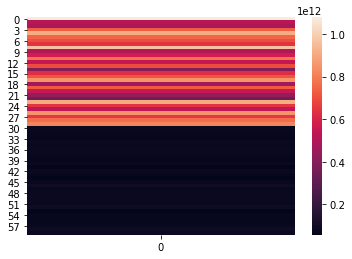

In [14]:
print(gradients_before_burnin[:D].sum())
print(gradients_before_burnin[D:].sum())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(inf, device='cuda:0')
tensor(2.1358e+20, device='cuda:0')


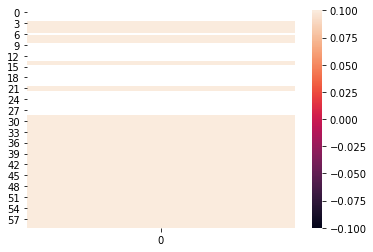

In [15]:
print(gradient_post_burn_in[:D].sum())
print(gradient_post_burn_in[D:].sum())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(637395., device='cuda:0')
tensor(99885.0781, device='cuda:0')


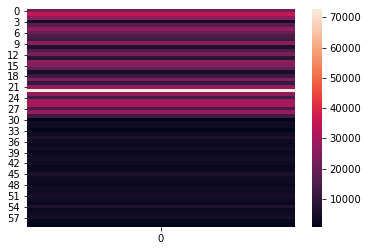

In [16]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(136188.5312, device='cuda:0')
tensor(48131.4570, device='cuda:0')


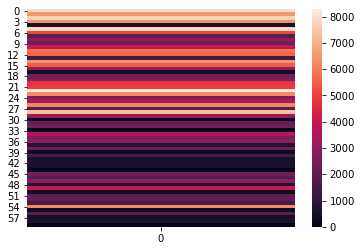

In [17]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[(D):].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [18]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(88057.0781, device='cuda:0')

**VAE_Gumbel_NInsta test here**

In [19]:
vae_gumbel_truncated = VAE_Gumbel_NInsta(2*D, 100, 20, k = 3*z_size, t = global_t)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [20]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      Dim = 2*D)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += vae_gumbel_truncated.subset_indices.sum(dim = 0)

Train Epoch: 1 [0/8000 (0%)]	Loss: 41.294006
Train Epoch: 1 [1280/8000 (16%)]	Loss: 40.674961
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.221031
Train Epoch: 1 [3840/8000 (48%)]	Loss: 39.730396
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.082882
Train Epoch: 1 [6400/8000 (80%)]	Loss: 38.695461
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.169300
====> Epoch: 1 Average loss: 39.6300
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.003162
Train Epoch: 2 [1280/8000 (16%)]	Loss: 37.516251
Train Epoch: 2 [2560/8000 (32%)]	Loss: 36.777893
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.157810
Train Epoch: 2 [5120/8000 (64%)]	Loss: 35.287170
Train Epoch: 2 [6400/8000 (80%)]	Loss: 35.275192
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.297264
====> Epoch: 2 Average loss: 36.0261
Train Epoch: 3 [0/8000 (0%)]	Loss: 34.226944
Train Epoch: 3 [1280/8000 (16%)]	Loss: 34.083256
Train Epoch: 3 [2560/8000 (32%)]	Loss: 34.100769
Train Epoch: 3 [3840/8000 (48%)]	Loss: 33.873367
Train Epoch: 3 [5120/8000 (64%)]	Loss: 33.942493
Train E

Train Epoch: 22 [6400/8000 (80%)]	Loss: 31.282536
Train Epoch: 22 [7680/8000 (96%)]	Loss: 31.381838
====> Epoch: 22 Average loss: 31.2099
Train Epoch: 23 [0/8000 (0%)]	Loss: 31.025547
Train Epoch: 23 [1280/8000 (16%)]	Loss: 31.291489
Train Epoch: 23 [2560/8000 (32%)]	Loss: 31.050579
Train Epoch: 23 [3840/8000 (48%)]	Loss: 30.966213
Train Epoch: 23 [5120/8000 (64%)]	Loss: 30.993820
Train Epoch: 23 [6400/8000 (80%)]	Loss: 31.017805
Train Epoch: 23 [7680/8000 (96%)]	Loss: 31.036785
====> Epoch: 23 Average loss: 31.1402
Train Epoch: 24 [0/8000 (0%)]	Loss: 31.918943
Train Epoch: 24 [1280/8000 (16%)]	Loss: 31.320900
Train Epoch: 24 [2560/8000 (32%)]	Loss: 31.211248
Train Epoch: 24 [3840/8000 (48%)]	Loss: 31.059959
Train Epoch: 24 [5120/8000 (64%)]	Loss: 30.856218
Train Epoch: 24 [6400/8000 (80%)]	Loss: 31.227531
Train Epoch: 24 [7680/8000 (96%)]	Loss: 31.224648
====> Epoch: 24 Average loss: 31.0960
Train Epoch: 25 [0/8000 (0%)]	Loss: 31.112539
Train Epoch: 25 [1280/8000 (16%)]	Loss: 31.36223

Train Epoch: 44 [1280/8000 (16%)]	Loss: 30.391024
Train Epoch: 44 [2560/8000 (32%)]	Loss: 30.638435
Train Epoch: 44 [3840/8000 (48%)]	Loss: 30.346529
Train Epoch: 44 [5120/8000 (64%)]	Loss: 30.761217
Train Epoch: 44 [6400/8000 (80%)]	Loss: 30.469156
Train Epoch: 44 [7680/8000 (96%)]	Loss: 30.778421
====> Epoch: 44 Average loss: 30.5884
Train Epoch: 45 [0/8000 (0%)]	Loss: 30.483011
Train Epoch: 45 [1280/8000 (16%)]	Loss: 30.588219
Train Epoch: 45 [2560/8000 (32%)]	Loss: 30.309889
Train Epoch: 45 [3840/8000 (48%)]	Loss: 30.146250
Train Epoch: 45 [5120/8000 (64%)]	Loss: 30.647715
Train Epoch: 45 [6400/8000 (80%)]	Loss: 30.454983
Train Epoch: 45 [7680/8000 (96%)]	Loss: 30.327620
====> Epoch: 45 Average loss: 30.5869
Train Epoch: 46 [0/8000 (0%)]	Loss: 30.521866
Train Epoch: 46 [1280/8000 (16%)]	Loss: 30.603550
Train Epoch: 46 [2560/8000 (32%)]	Loss: 30.565311
Train Epoch: 46 [3840/8000 (48%)]	Loss: 30.677940
Train Epoch: 46 [5120/8000 (64%)]	Loss: 30.583948
Train Epoch: 46 [6400/8000 (80%)

Train Epoch: 65 [5120/8000 (64%)]	Loss: 30.504795
Train Epoch: 65 [6400/8000 (80%)]	Loss: 30.165766
Train Epoch: 65 [7680/8000 (96%)]	Loss: 30.314869
====> Epoch: 65 Average loss: 30.4092
Train Epoch: 66 [0/8000 (0%)]	Loss: 30.375870
Train Epoch: 66 [1280/8000 (16%)]	Loss: 30.395910
Train Epoch: 66 [2560/8000 (32%)]	Loss: 30.283554
Train Epoch: 66 [3840/8000 (48%)]	Loss: 30.771353
Train Epoch: 66 [5120/8000 (64%)]	Loss: 30.294895
Train Epoch: 66 [6400/8000 (80%)]	Loss: 30.121487
Train Epoch: 66 [7680/8000 (96%)]	Loss: 30.338730
====> Epoch: 66 Average loss: 30.4054
Train Epoch: 67 [0/8000 (0%)]	Loss: 30.416710
Train Epoch: 67 [1280/8000 (16%)]	Loss: 30.591087
Train Epoch: 67 [2560/8000 (32%)]	Loss: 30.293823
Train Epoch: 67 [3840/8000 (48%)]	Loss: 30.406685
Train Epoch: 67 [5120/8000 (64%)]	Loss: 30.527002
Train Epoch: 67 [6400/8000 (80%)]	Loss: 30.261524
Train Epoch: 67 [7680/8000 (96%)]	Loss: 30.396797
====> Epoch: 67 Average loss: 30.3882
Train Epoch: 68 [0/8000 (0%)]	Loss: 30.38037

Train Epoch: 87 [1280/8000 (16%)]	Loss: 30.178507
Train Epoch: 87 [2560/8000 (32%)]	Loss: 30.046175
Train Epoch: 87 [3840/8000 (48%)]	Loss: 30.250492
Train Epoch: 87 [5120/8000 (64%)]	Loss: 30.332193
Train Epoch: 87 [6400/8000 (80%)]	Loss: 30.362762
Train Epoch: 87 [7680/8000 (96%)]	Loss: 29.891991
====> Epoch: 87 Average loss: 30.3031
Train Epoch: 88 [0/8000 (0%)]	Loss: 30.182297
Train Epoch: 88 [1280/8000 (16%)]	Loss: 30.169449
Train Epoch: 88 [2560/8000 (32%)]	Loss: 30.114155
Train Epoch: 88 [3840/8000 (48%)]	Loss: 30.305826
Train Epoch: 88 [5120/8000 (64%)]	Loss: 30.077404
Train Epoch: 88 [6400/8000 (80%)]	Loss: 30.075031
Train Epoch: 88 [7680/8000 (96%)]	Loss: 30.232018
====> Epoch: 88 Average loss: 30.2972
Train Epoch: 89 [0/8000 (0%)]	Loss: 30.257387
Train Epoch: 89 [1280/8000 (16%)]	Loss: 30.601273
Train Epoch: 89 [2560/8000 (32%)]	Loss: 30.366232
Train Epoch: 89 [3840/8000 (48%)]	Loss: 30.206963
Train Epoch: 89 [5120/8000 (64%)]	Loss: 30.453295
Train Epoch: 89 [6400/8000 (80%)

Train Epoch: 108 [3840/8000 (48%)]	Loss: 30.096375
Train Epoch: 108 [5120/8000 (64%)]	Loss: 30.470484
Train Epoch: 108 [6400/8000 (80%)]	Loss: 30.071169
Train Epoch: 108 [7680/8000 (96%)]	Loss: 30.323212
====> Epoch: 108 Average loss: 30.2730
Train Epoch: 109 [0/8000 (0%)]	Loss: 29.916391
Train Epoch: 109 [1280/8000 (16%)]	Loss: 30.356712
Train Epoch: 109 [2560/8000 (32%)]	Loss: 30.188297
Train Epoch: 109 [3840/8000 (48%)]	Loss: 30.205364
Train Epoch: 109 [5120/8000 (64%)]	Loss: 30.135725
Train Epoch: 109 [6400/8000 (80%)]	Loss: 30.342896
Train Epoch: 109 [7680/8000 (96%)]	Loss: 30.006624
====> Epoch: 109 Average loss: 30.2654
Train Epoch: 110 [0/8000 (0%)]	Loss: 30.321934
Train Epoch: 110 [1280/8000 (16%)]	Loss: 30.168152
Train Epoch: 110 [2560/8000 (32%)]	Loss: 30.525772
Train Epoch: 110 [3840/8000 (48%)]	Loss: 30.619318
Train Epoch: 110 [5120/8000 (64%)]	Loss: 30.277552
Train Epoch: 110 [6400/8000 (80%)]	Loss: 30.594578
Train Epoch: 110 [7680/8000 (96%)]	Loss: 30.283054
====> Epoch:

Train Epoch: 129 [3840/8000 (48%)]	Loss: 30.300077
Train Epoch: 129 [5120/8000 (64%)]	Loss: 30.284035
Train Epoch: 129 [6400/8000 (80%)]	Loss: 30.272709
Train Epoch: 129 [7680/8000 (96%)]	Loss: 30.167391
====> Epoch: 129 Average loss: 30.2379
Train Epoch: 130 [0/8000 (0%)]	Loss: 30.419777
Train Epoch: 130 [1280/8000 (16%)]	Loss: 30.234077
Train Epoch: 130 [2560/8000 (32%)]	Loss: 30.203911
Train Epoch: 130 [3840/8000 (48%)]	Loss: 30.392639
Train Epoch: 130 [5120/8000 (64%)]	Loss: 29.997576
Train Epoch: 130 [6400/8000 (80%)]	Loss: 30.049372
Train Epoch: 130 [7680/8000 (96%)]	Loss: 30.099876
====> Epoch: 130 Average loss: 30.2489
Train Epoch: 131 [0/8000 (0%)]	Loss: 30.265560
Train Epoch: 131 [1280/8000 (16%)]	Loss: 30.282536
Train Epoch: 131 [2560/8000 (32%)]	Loss: 30.135750
Train Epoch: 131 [3840/8000 (48%)]	Loss: 30.171234
Train Epoch: 131 [5120/8000 (64%)]	Loss: 29.803310
Train Epoch: 131 [6400/8000 (80%)]	Loss: 30.277721
Train Epoch: 131 [7680/8000 (96%)]	Loss: 30.091141
====> Epoch:

Train Epoch: 150 [3840/8000 (48%)]	Loss: 29.884279
Train Epoch: 150 [5120/8000 (64%)]	Loss: 29.851887
Train Epoch: 150 [6400/8000 (80%)]	Loss: 30.449347
Train Epoch: 150 [7680/8000 (96%)]	Loss: 30.058388
====> Epoch: 150 Average loss: 30.2107
Train Epoch: 151 [0/8000 (0%)]	Loss: 30.360134
Train Epoch: 151 [1280/8000 (16%)]	Loss: 30.410763
Train Epoch: 151 [2560/8000 (32%)]	Loss: 30.515905
Train Epoch: 151 [3840/8000 (48%)]	Loss: 30.636078
Train Epoch: 151 [5120/8000 (64%)]	Loss: 30.428680
Train Epoch: 151 [6400/8000 (80%)]	Loss: 30.070696
Train Epoch: 151 [7680/8000 (96%)]	Loss: 30.312197
====> Epoch: 151 Average loss: 30.2140
Train Epoch: 152 [0/8000 (0%)]	Loss: 30.043888
Train Epoch: 152 [1280/8000 (16%)]	Loss: 30.260092
Train Epoch: 152 [2560/8000 (32%)]	Loss: 30.433641
Train Epoch: 152 [3840/8000 (48%)]	Loss: 30.696085
Train Epoch: 152 [5120/8000 (64%)]	Loss: 30.505888
Train Epoch: 152 [6400/8000 (80%)]	Loss: 30.654621
Train Epoch: 152 [7680/8000 (96%)]	Loss: 30.448204
====> Epoch:

Train Epoch: 171 [3840/8000 (48%)]	Loss: 30.382788
Train Epoch: 171 [5120/8000 (64%)]	Loss: 30.348322
Train Epoch: 171 [6400/8000 (80%)]	Loss: 30.213768
Train Epoch: 171 [7680/8000 (96%)]	Loss: 30.093328
====> Epoch: 171 Average loss: 30.2098
Train Epoch: 172 [0/8000 (0%)]	Loss: 30.419416
Train Epoch: 172 [1280/8000 (16%)]	Loss: 30.374466
Train Epoch: 172 [2560/8000 (32%)]	Loss: 30.560352
Train Epoch: 172 [3840/8000 (48%)]	Loss: 30.192398
Train Epoch: 172 [5120/8000 (64%)]	Loss: 30.718836
Train Epoch: 172 [6400/8000 (80%)]	Loss: 30.384720
Train Epoch: 172 [7680/8000 (96%)]	Loss: 30.365643
====> Epoch: 172 Average loss: 30.1942
Train Epoch: 173 [0/8000 (0%)]	Loss: 30.342354
Train Epoch: 173 [1280/8000 (16%)]	Loss: 30.363396
Train Epoch: 173 [2560/8000 (32%)]	Loss: 29.923859
Train Epoch: 173 [3840/8000 (48%)]	Loss: 30.206079
Train Epoch: 173 [5120/8000 (64%)]	Loss: 30.238119
Train Epoch: 173 [6400/8000 (80%)]	Loss: 30.006392
Train Epoch: 173 [7680/8000 (96%)]	Loss: 30.031677
====> Epoch:

Train Epoch: 192 [3840/8000 (48%)]	Loss: 30.131165
Train Epoch: 192 [5120/8000 (64%)]	Loss: 30.166727
Train Epoch: 192 [6400/8000 (80%)]	Loss: 30.362795
Train Epoch: 192 [7680/8000 (96%)]	Loss: 30.088804
====> Epoch: 192 Average loss: 30.2174
Train Epoch: 193 [0/8000 (0%)]	Loss: 30.000193
Train Epoch: 193 [1280/8000 (16%)]	Loss: 30.587288
Train Epoch: 193 [2560/8000 (32%)]	Loss: 30.289850
Train Epoch: 193 [3840/8000 (48%)]	Loss: 30.163725
Train Epoch: 193 [5120/8000 (64%)]	Loss: 30.369944
Train Epoch: 193 [6400/8000 (80%)]	Loss: 29.901571
Train Epoch: 193 [7680/8000 (96%)]	Loss: 30.363712
====> Epoch: 193 Average loss: 30.1870
Train Epoch: 194 [0/8000 (0%)]	Loss: 30.007215
Train Epoch: 194 [1280/8000 (16%)]	Loss: 30.274511
Train Epoch: 194 [2560/8000 (32%)]	Loss: 30.058710
Train Epoch: 194 [3840/8000 (48%)]	Loss: 29.954018
Train Epoch: 194 [5120/8000 (64%)]	Loss: 30.089106
Train Epoch: 194 [6400/8000 (80%)]	Loss: 30.106995
Train Epoch: 194 [7680/8000 (96%)]	Loss: 30.161095
====> Epoch:

Train Epoch: 213 [3840/8000 (48%)]	Loss: 30.151472
Train Epoch: 213 [5120/8000 (64%)]	Loss: 30.430012
Train Epoch: 213 [6400/8000 (80%)]	Loss: 30.438835
Train Epoch: 213 [7680/8000 (96%)]	Loss: 30.664669
====> Epoch: 213 Average loss: 30.2313
Train Epoch: 214 [0/8000 (0%)]	Loss: 30.115610
Train Epoch: 214 [1280/8000 (16%)]	Loss: 30.152273
Train Epoch: 214 [2560/8000 (32%)]	Loss: 30.545355
Train Epoch: 214 [3840/8000 (48%)]	Loss: 30.214430
Train Epoch: 214 [5120/8000 (64%)]	Loss: 30.416765
Train Epoch: 214 [6400/8000 (80%)]	Loss: 30.481083
Train Epoch: 214 [7680/8000 (96%)]	Loss: 30.650183
====> Epoch: 214 Average loss: 30.2039
Train Epoch: 215 [0/8000 (0%)]	Loss: 30.464237
Train Epoch: 215 [1280/8000 (16%)]	Loss: 30.322521
Train Epoch: 215 [2560/8000 (32%)]	Loss: 29.698299
Train Epoch: 215 [3840/8000 (48%)]	Loss: 30.096378
Train Epoch: 215 [5120/8000 (64%)]	Loss: 30.242702
Train Epoch: 215 [6400/8000 (80%)]	Loss: 29.914900
Train Epoch: 215 [7680/8000 (96%)]	Loss: 30.248981
====> Epoch:

Train Epoch: 234 [3840/8000 (48%)]	Loss: 30.089245
Train Epoch: 234 [5120/8000 (64%)]	Loss: 30.026051
Train Epoch: 234 [6400/8000 (80%)]	Loss: 30.198946
Train Epoch: 234 [7680/8000 (96%)]	Loss: 30.062700
====> Epoch: 234 Average loss: 30.1913
Train Epoch: 235 [0/8000 (0%)]	Loss: 30.408146
Train Epoch: 235 [1280/8000 (16%)]	Loss: 30.216909
Train Epoch: 235 [2560/8000 (32%)]	Loss: 29.922234
Train Epoch: 235 [3840/8000 (48%)]	Loss: 30.513023
Train Epoch: 235 [5120/8000 (64%)]	Loss: 30.387337
Train Epoch: 235 [6400/8000 (80%)]	Loss: 30.375715
Train Epoch: 235 [7680/8000 (96%)]	Loss: 30.271023
====> Epoch: 235 Average loss: 30.2091
Train Epoch: 236 [0/8000 (0%)]	Loss: 30.152571
Train Epoch: 236 [1280/8000 (16%)]	Loss: 30.185419
Train Epoch: 236 [2560/8000 (32%)]	Loss: 30.069292
Train Epoch: 236 [3840/8000 (48%)]	Loss: 30.268948
Train Epoch: 236 [5120/8000 (64%)]	Loss: 29.933870
Train Epoch: 236 [6400/8000 (80%)]	Loss: 30.068043
Train Epoch: 236 [7680/8000 (96%)]	Loss: 30.040859
====> Epoch:

Train Epoch: 255 [3840/8000 (48%)]	Loss: 30.380520
Train Epoch: 255 [5120/8000 (64%)]	Loss: 30.070347
Train Epoch: 255 [6400/8000 (80%)]	Loss: 30.090445
Train Epoch: 255 [7680/8000 (96%)]	Loss: 30.184181
====> Epoch: 255 Average loss: 30.1943
Train Epoch: 256 [0/8000 (0%)]	Loss: 30.159887
Train Epoch: 256 [1280/8000 (16%)]	Loss: 30.230589
Train Epoch: 256 [2560/8000 (32%)]	Loss: 29.920778
Train Epoch: 256 [3840/8000 (48%)]	Loss: 30.245010
Train Epoch: 256 [5120/8000 (64%)]	Loss: 29.940693
Train Epoch: 256 [6400/8000 (80%)]	Loss: 30.086391
Train Epoch: 256 [7680/8000 (96%)]	Loss: 30.161634
====> Epoch: 256 Average loss: 30.2055
Train Epoch: 257 [0/8000 (0%)]	Loss: 30.491133
Train Epoch: 257 [1280/8000 (16%)]	Loss: 30.469748
Train Epoch: 257 [2560/8000 (32%)]	Loss: 30.407446
Train Epoch: 257 [3840/8000 (48%)]	Loss: 30.079481
Train Epoch: 257 [5120/8000 (64%)]	Loss: 29.994938
Train Epoch: 257 [6400/8000 (80%)]	Loss: 30.361095
Train Epoch: 257 [7680/8000 (96%)]	Loss: 29.972916
====> Epoch:

Train Epoch: 276 [3840/8000 (48%)]	Loss: 30.475616
Train Epoch: 276 [5120/8000 (64%)]	Loss: 29.919579
Train Epoch: 276 [6400/8000 (80%)]	Loss: 30.803923
Train Epoch: 276 [7680/8000 (96%)]	Loss: 30.224617
====> Epoch: 276 Average loss: 30.1819
Train Epoch: 277 [0/8000 (0%)]	Loss: 30.076050
Train Epoch: 277 [1280/8000 (16%)]	Loss: 29.776440
Train Epoch: 277 [2560/8000 (32%)]	Loss: 30.430311
Train Epoch: 277 [3840/8000 (48%)]	Loss: 30.116207
Train Epoch: 277 [5120/8000 (64%)]	Loss: 29.936178
Train Epoch: 277 [6400/8000 (80%)]	Loss: 29.872826
Train Epoch: 277 [7680/8000 (96%)]	Loss: 30.453358
====> Epoch: 277 Average loss: 30.1931
Train Epoch: 278 [0/8000 (0%)]	Loss: 30.105238
Train Epoch: 278 [1280/8000 (16%)]	Loss: 29.989845
Train Epoch: 278 [2560/8000 (32%)]	Loss: 30.199198
Train Epoch: 278 [3840/8000 (48%)]	Loss: 29.922333
Train Epoch: 278 [5120/8000 (64%)]	Loss: 30.197952
Train Epoch: 278 [6400/8000 (80%)]	Loss: 30.565453
Train Epoch: 278 [7680/8000 (96%)]	Loss: 29.864925
====> Epoch:

Train Epoch: 297 [3840/8000 (48%)]	Loss: 30.179266
Train Epoch: 297 [5120/8000 (64%)]	Loss: 30.111853
Train Epoch: 297 [6400/8000 (80%)]	Loss: 30.151140
Train Epoch: 297 [7680/8000 (96%)]	Loss: 30.060818
====> Epoch: 297 Average loss: 30.1663
Train Epoch: 298 [0/8000 (0%)]	Loss: 30.275993
Train Epoch: 298 [1280/8000 (16%)]	Loss: 30.268492
Train Epoch: 298 [2560/8000 (32%)]	Loss: 29.984135
Train Epoch: 298 [3840/8000 (48%)]	Loss: 30.172707
Train Epoch: 298 [5120/8000 (64%)]	Loss: 30.364231
Train Epoch: 298 [6400/8000 (80%)]	Loss: 30.218153
Train Epoch: 298 [7680/8000 (96%)]	Loss: 30.609564
====> Epoch: 298 Average loss: 30.1779
Train Epoch: 299 [0/8000 (0%)]	Loss: 30.041473
Train Epoch: 299 [1280/8000 (16%)]	Loss: 30.299482
Train Epoch: 299 [2560/8000 (32%)]	Loss: 30.195595
Train Epoch: 299 [3840/8000 (48%)]	Loss: 30.448664
Train Epoch: 299 [5120/8000 (64%)]	Loss: 30.196526
Train Epoch: 299 [6400/8000 (80%)]	Loss: 30.198639
Train Epoch: 299 [7680/8000 (96%)]	Loss: 30.287682
====> Epoch:

Train Epoch: 318 [3840/8000 (48%)]	Loss: 30.003923
Train Epoch: 318 [5120/8000 (64%)]	Loss: 30.297226
Train Epoch: 318 [6400/8000 (80%)]	Loss: 30.289658
Train Epoch: 318 [7680/8000 (96%)]	Loss: 30.121279
====> Epoch: 318 Average loss: 30.1396
Train Epoch: 319 [0/8000 (0%)]	Loss: 30.362047
Train Epoch: 319 [1280/8000 (16%)]	Loss: 30.360249
Train Epoch: 319 [2560/8000 (32%)]	Loss: 30.392157
Train Epoch: 319 [3840/8000 (48%)]	Loss: 30.043024
Train Epoch: 319 [5120/8000 (64%)]	Loss: 30.017567
Train Epoch: 319 [6400/8000 (80%)]	Loss: 29.989334
Train Epoch: 319 [7680/8000 (96%)]	Loss: 30.157738
====> Epoch: 319 Average loss: 30.1492
Train Epoch: 320 [0/8000 (0%)]	Loss: 29.938625
Train Epoch: 320 [1280/8000 (16%)]	Loss: 30.286215
Train Epoch: 320 [2560/8000 (32%)]	Loss: 30.080505
Train Epoch: 320 [3840/8000 (48%)]	Loss: 30.348793
Train Epoch: 320 [5120/8000 (64%)]	Loss: 30.059395
Train Epoch: 320 [6400/8000 (80%)]	Loss: 30.182913
Train Epoch: 320 [7680/8000 (96%)]	Loss: 30.301086
====> Epoch:

Train Epoch: 339 [3840/8000 (48%)]	Loss: 30.182997
Train Epoch: 339 [5120/8000 (64%)]	Loss: 30.089581
Train Epoch: 339 [6400/8000 (80%)]	Loss: 30.101091
Train Epoch: 339 [7680/8000 (96%)]	Loss: 30.220768
====> Epoch: 339 Average loss: 30.1223
Train Epoch: 340 [0/8000 (0%)]	Loss: 30.139288
Train Epoch: 340 [1280/8000 (16%)]	Loss: 29.927477
Train Epoch: 340 [2560/8000 (32%)]	Loss: 29.779747
Train Epoch: 340 [3840/8000 (48%)]	Loss: 30.159437
Train Epoch: 340 [5120/8000 (64%)]	Loss: 29.806047
Train Epoch: 340 [6400/8000 (80%)]	Loss: 30.133924
Train Epoch: 340 [7680/8000 (96%)]	Loss: 30.092829
====> Epoch: 340 Average loss: 30.1070
Train Epoch: 341 [0/8000 (0%)]	Loss: 30.256426
Train Epoch: 341 [1280/8000 (16%)]	Loss: 30.089981
Train Epoch: 341 [2560/8000 (32%)]	Loss: 30.358246
Train Epoch: 341 [3840/8000 (48%)]	Loss: 30.125885
Train Epoch: 341 [5120/8000 (64%)]	Loss: 30.268991
Train Epoch: 341 [6400/8000 (80%)]	Loss: 30.330952
Train Epoch: 341 [7680/8000 (96%)]	Loss: 30.017445
====> Epoch:

Train Epoch: 360 [3840/8000 (48%)]	Loss: 30.420675
Train Epoch: 360 [5120/8000 (64%)]	Loss: 29.766033
Train Epoch: 360 [6400/8000 (80%)]	Loss: 30.296032
Train Epoch: 360 [7680/8000 (96%)]	Loss: 30.230341
====> Epoch: 360 Average loss: 30.0845
Train Epoch: 361 [0/8000 (0%)]	Loss: 30.345486
Train Epoch: 361 [1280/8000 (16%)]	Loss: 30.273596
Train Epoch: 361 [2560/8000 (32%)]	Loss: 29.993427
Train Epoch: 361 [3840/8000 (48%)]	Loss: 30.061996
Train Epoch: 361 [5120/8000 (64%)]	Loss: 30.131536
Train Epoch: 361 [6400/8000 (80%)]	Loss: 30.421658
Train Epoch: 361 [7680/8000 (96%)]	Loss: 30.105413
====> Epoch: 361 Average loss: 30.1014
Train Epoch: 362 [0/8000 (0%)]	Loss: 30.072397
Train Epoch: 362 [1280/8000 (16%)]	Loss: 29.922609
Train Epoch: 362 [2560/8000 (32%)]	Loss: 30.309811
Train Epoch: 362 [3840/8000 (48%)]	Loss: 30.046808
Train Epoch: 362 [5120/8000 (64%)]	Loss: 30.126682
Train Epoch: 362 [6400/8000 (80%)]	Loss: 29.918795
Train Epoch: 362 [7680/8000 (96%)]	Loss: 30.074749
====> Epoch:

Train Epoch: 381 [3840/8000 (48%)]	Loss: 29.613770
Train Epoch: 381 [5120/8000 (64%)]	Loss: 29.724655
Train Epoch: 381 [6400/8000 (80%)]	Loss: 29.804926
Train Epoch: 381 [7680/8000 (96%)]	Loss: 29.961620
====> Epoch: 381 Average loss: 30.0623
Train Epoch: 382 [0/8000 (0%)]	Loss: 30.183109
Train Epoch: 382 [1280/8000 (16%)]	Loss: 29.997011
Train Epoch: 382 [2560/8000 (32%)]	Loss: 29.902405
Train Epoch: 382 [3840/8000 (48%)]	Loss: 29.969408
Train Epoch: 382 [5120/8000 (64%)]	Loss: 30.207787
Train Epoch: 382 [6400/8000 (80%)]	Loss: 30.282871
Train Epoch: 382 [7680/8000 (96%)]	Loss: 29.998310
====> Epoch: 382 Average loss: 30.0512
Train Epoch: 383 [0/8000 (0%)]	Loss: 30.269903
Train Epoch: 383 [1280/8000 (16%)]	Loss: 30.299252
Train Epoch: 383 [2560/8000 (32%)]	Loss: 30.171640
Train Epoch: 383 [3840/8000 (48%)]	Loss: 29.931541
Train Epoch: 383 [5120/8000 (64%)]	Loss: 29.629395
Train Epoch: 383 [6400/8000 (80%)]	Loss: 29.757893
Train Epoch: 383 [7680/8000 (96%)]	Loss: 29.963238
====> Epoch:

Train Epoch: 402 [3840/8000 (48%)]	Loss: 30.175789
Train Epoch: 402 [5120/8000 (64%)]	Loss: 29.887989
Train Epoch: 402 [6400/8000 (80%)]	Loss: 29.995186
Train Epoch: 402 [7680/8000 (96%)]	Loss: 29.969345
====> Epoch: 402 Average loss: 30.0551
Train Epoch: 403 [0/8000 (0%)]	Loss: 30.010254
Train Epoch: 403 [1280/8000 (16%)]	Loss: 29.954784
Train Epoch: 403 [2560/8000 (32%)]	Loss: 30.040890
Train Epoch: 403 [3840/8000 (48%)]	Loss: 30.265469
Train Epoch: 403 [5120/8000 (64%)]	Loss: 30.322939
Train Epoch: 403 [6400/8000 (80%)]	Loss: 30.151382
Train Epoch: 403 [7680/8000 (96%)]	Loss: 30.137228
====> Epoch: 403 Average loss: 30.0447
Train Epoch: 404 [0/8000 (0%)]	Loss: 29.941679
Train Epoch: 404 [1280/8000 (16%)]	Loss: 30.045923
Train Epoch: 404 [2560/8000 (32%)]	Loss: 30.126509
Train Epoch: 404 [3840/8000 (48%)]	Loss: 30.178600
Train Epoch: 404 [5120/8000 (64%)]	Loss: 30.092436
Train Epoch: 404 [6400/8000 (80%)]	Loss: 30.893074
Train Epoch: 404 [7680/8000 (96%)]	Loss: 29.921640
====> Epoch:

Train Epoch: 423 [3840/8000 (48%)]	Loss: 29.934706
Train Epoch: 423 [5120/8000 (64%)]	Loss: 30.004772
Train Epoch: 423 [6400/8000 (80%)]	Loss: 30.037987
Train Epoch: 423 [7680/8000 (96%)]	Loss: 30.034168
====> Epoch: 423 Average loss: 29.9948
Train Epoch: 424 [0/8000 (0%)]	Loss: 30.033138
Train Epoch: 424 [1280/8000 (16%)]	Loss: 29.767550
Train Epoch: 424 [2560/8000 (32%)]	Loss: 29.940527
Train Epoch: 424 [3840/8000 (48%)]	Loss: 30.218781
Train Epoch: 424 [5120/8000 (64%)]	Loss: 29.631599
Train Epoch: 424 [6400/8000 (80%)]	Loss: 30.001150
Train Epoch: 424 [7680/8000 (96%)]	Loss: 29.915234
====> Epoch: 424 Average loss: 30.0139
Train Epoch: 425 [0/8000 (0%)]	Loss: 30.286678
Train Epoch: 425 [1280/8000 (16%)]	Loss: 30.213602
Train Epoch: 425 [2560/8000 (32%)]	Loss: 29.711617
Train Epoch: 425 [3840/8000 (48%)]	Loss: 29.979036
Train Epoch: 425 [5120/8000 (64%)]	Loss: 30.019054
Train Epoch: 425 [6400/8000 (80%)]	Loss: 29.868860
Train Epoch: 425 [7680/8000 (96%)]	Loss: 30.085268
====> Epoch:

Train Epoch: 444 [3840/8000 (48%)]	Loss: 29.783510
Train Epoch: 444 [5120/8000 (64%)]	Loss: 29.813013
Train Epoch: 444 [6400/8000 (80%)]	Loss: 29.951902
Train Epoch: 444 [7680/8000 (96%)]	Loss: 29.865713
====> Epoch: 444 Average loss: 29.9914
Train Epoch: 445 [0/8000 (0%)]	Loss: 29.677734
Train Epoch: 445 [1280/8000 (16%)]	Loss: 30.274433
Train Epoch: 445 [2560/8000 (32%)]	Loss: 30.326160
Train Epoch: 445 [3840/8000 (48%)]	Loss: 30.068733
Train Epoch: 445 [5120/8000 (64%)]	Loss: 29.643242
Train Epoch: 445 [6400/8000 (80%)]	Loss: 29.815924
Train Epoch: 445 [7680/8000 (96%)]	Loss: 30.231411
====> Epoch: 445 Average loss: 29.9869
Train Epoch: 446 [0/8000 (0%)]	Loss: 30.131243
Train Epoch: 446 [1280/8000 (16%)]	Loss: 29.837784
Train Epoch: 446 [2560/8000 (32%)]	Loss: 30.374887
Train Epoch: 446 [3840/8000 (48%)]	Loss: 29.875032
Train Epoch: 446 [5120/8000 (64%)]	Loss: 29.824734
Train Epoch: 446 [6400/8000 (80%)]	Loss: 30.213346
Train Epoch: 446 [7680/8000 (96%)]	Loss: 30.115992
====> Epoch:

Train Epoch: 465 [3840/8000 (48%)]	Loss: 30.051725
Train Epoch: 465 [5120/8000 (64%)]	Loss: 30.155891
Train Epoch: 465 [6400/8000 (80%)]	Loss: 30.266390
Train Epoch: 465 [7680/8000 (96%)]	Loss: 30.112345
====> Epoch: 465 Average loss: 29.9813
Train Epoch: 466 [0/8000 (0%)]	Loss: 30.215967
Train Epoch: 466 [1280/8000 (16%)]	Loss: 29.864027
Train Epoch: 466 [2560/8000 (32%)]	Loss: 29.917206
Train Epoch: 466 [3840/8000 (48%)]	Loss: 30.123886
Train Epoch: 466 [5120/8000 (64%)]	Loss: 29.753468
Train Epoch: 466 [6400/8000 (80%)]	Loss: 29.767427
Train Epoch: 466 [7680/8000 (96%)]	Loss: 29.833212
====> Epoch: 466 Average loss: 29.9587
Train Epoch: 467 [0/8000 (0%)]	Loss: 29.881592
Train Epoch: 467 [1280/8000 (16%)]	Loss: 29.924387
Train Epoch: 467 [2560/8000 (32%)]	Loss: 30.012972
Train Epoch: 467 [3840/8000 (48%)]	Loss: 30.130840
Train Epoch: 467 [5120/8000 (64%)]	Loss: 30.124468
Train Epoch: 467 [6400/8000 (80%)]	Loss: 29.906775
Train Epoch: 467 [7680/8000 (96%)]	Loss: 29.990211
====> Epoch:

Train Epoch: 486 [3840/8000 (48%)]	Loss: 29.915602
Train Epoch: 486 [5120/8000 (64%)]	Loss: 29.973923
Train Epoch: 486 [6400/8000 (80%)]	Loss: 30.091537
Train Epoch: 486 [7680/8000 (96%)]	Loss: 29.607044
====> Epoch: 486 Average loss: 29.9353
Train Epoch: 487 [0/8000 (0%)]	Loss: 30.092516
Train Epoch: 487 [1280/8000 (16%)]	Loss: 30.088530
Train Epoch: 487 [2560/8000 (32%)]	Loss: 29.622282
Train Epoch: 487 [3840/8000 (48%)]	Loss: 30.337719
Train Epoch: 487 [5120/8000 (64%)]	Loss: 29.794832
Train Epoch: 487 [6400/8000 (80%)]	Loss: 29.543119
Train Epoch: 487 [7680/8000 (96%)]	Loss: 30.029179
====> Epoch: 487 Average loss: 29.9400
Train Epoch: 488 [0/8000 (0%)]	Loss: 29.849018
Train Epoch: 488 [1280/8000 (16%)]	Loss: 30.028162
Train Epoch: 488 [2560/8000 (32%)]	Loss: 30.017376
Train Epoch: 488 [3840/8000 (48%)]	Loss: 30.102016
Train Epoch: 488 [5120/8000 (64%)]	Loss: 29.970299
Train Epoch: 488 [6400/8000 (80%)]	Loss: 29.745474
Train Epoch: 488 [7680/8000 (96%)]	Loss: 30.116478
====> Epoch:

Train Epoch: 507 [3840/8000 (48%)]	Loss: 29.571465
Train Epoch: 507 [5120/8000 (64%)]	Loss: 29.912592
Train Epoch: 507 [6400/8000 (80%)]	Loss: 29.438740
Train Epoch: 507 [7680/8000 (96%)]	Loss: 30.135162
====> Epoch: 507 Average loss: 29.9051
Train Epoch: 508 [0/8000 (0%)]	Loss: 29.743870
Train Epoch: 508 [1280/8000 (16%)]	Loss: 29.831871
Train Epoch: 508 [2560/8000 (32%)]	Loss: 29.950203
Train Epoch: 508 [3840/8000 (48%)]	Loss: 29.760891
Train Epoch: 508 [5120/8000 (64%)]	Loss: 29.563946
Train Epoch: 508 [6400/8000 (80%)]	Loss: 29.741148
Train Epoch: 508 [7680/8000 (96%)]	Loss: 30.269218
====> Epoch: 508 Average loss: 29.9106
Train Epoch: 509 [0/8000 (0%)]	Loss: 29.979746
Train Epoch: 509 [1280/8000 (16%)]	Loss: 29.707491
Train Epoch: 509 [2560/8000 (32%)]	Loss: 29.581871
Train Epoch: 509 [3840/8000 (48%)]	Loss: 30.130003
Train Epoch: 509 [5120/8000 (64%)]	Loss: 30.097424
Train Epoch: 509 [6400/8000 (80%)]	Loss: 29.559305
Train Epoch: 509 [7680/8000 (96%)]	Loss: 29.971350
====> Epoch:

Train Epoch: 528 [3840/8000 (48%)]	Loss: 29.987007
Train Epoch: 528 [5120/8000 (64%)]	Loss: 30.021584
Train Epoch: 528 [6400/8000 (80%)]	Loss: 29.919127
Train Epoch: 528 [7680/8000 (96%)]	Loss: 29.870325
====> Epoch: 528 Average loss: 29.8762
Train Epoch: 529 [0/8000 (0%)]	Loss: 29.683046
Train Epoch: 529 [1280/8000 (16%)]	Loss: 29.778101
Train Epoch: 529 [2560/8000 (32%)]	Loss: 29.956152
Train Epoch: 529 [3840/8000 (48%)]	Loss: 29.714649
Train Epoch: 529 [5120/8000 (64%)]	Loss: 30.005371
Train Epoch: 529 [6400/8000 (80%)]	Loss: 29.844437
Train Epoch: 529 [7680/8000 (96%)]	Loss: 30.134241
====> Epoch: 529 Average loss: 29.8866
Train Epoch: 530 [0/8000 (0%)]	Loss: 29.812834
Train Epoch: 530 [1280/8000 (16%)]	Loss: 30.274837
Train Epoch: 530 [2560/8000 (32%)]	Loss: 29.892214
Train Epoch: 530 [3840/8000 (48%)]	Loss: 29.981167
Train Epoch: 530 [5120/8000 (64%)]	Loss: 29.995932
Train Epoch: 530 [6400/8000 (80%)]	Loss: 29.917274
Train Epoch: 530 [7680/8000 (96%)]	Loss: 29.535563
====> Epoch:

Train Epoch: 549 [3840/8000 (48%)]	Loss: 30.085917
Train Epoch: 549 [5120/8000 (64%)]	Loss: 29.628534
Train Epoch: 549 [6400/8000 (80%)]	Loss: 30.060772
Train Epoch: 549 [7680/8000 (96%)]	Loss: 29.579880
====> Epoch: 549 Average loss: 29.8640
Train Epoch: 550 [0/8000 (0%)]	Loss: 30.037004
Train Epoch: 550 [1280/8000 (16%)]	Loss: 29.857126
Train Epoch: 550 [2560/8000 (32%)]	Loss: 29.966520
Train Epoch: 550 [3840/8000 (48%)]	Loss: 29.920950
Train Epoch: 550 [5120/8000 (64%)]	Loss: 30.084209
Train Epoch: 550 [6400/8000 (80%)]	Loss: 29.467911
Train Epoch: 550 [7680/8000 (96%)]	Loss: 30.004768
====> Epoch: 550 Average loss: 29.8568
Train Epoch: 551 [0/8000 (0%)]	Loss: 29.799965
Train Epoch: 551 [1280/8000 (16%)]	Loss: 30.171125
Train Epoch: 551 [2560/8000 (32%)]	Loss: 29.803900
Train Epoch: 551 [3840/8000 (48%)]	Loss: 29.744596
Train Epoch: 551 [5120/8000 (64%)]	Loss: 29.762976
Train Epoch: 551 [6400/8000 (80%)]	Loss: 30.187262
Train Epoch: 551 [7680/8000 (96%)]	Loss: 29.735924
====> Epoch:

Train Epoch: 570 [3840/8000 (48%)]	Loss: 29.927780
Train Epoch: 570 [5120/8000 (64%)]	Loss: 29.638351
Train Epoch: 570 [6400/8000 (80%)]	Loss: 29.814199
Train Epoch: 570 [7680/8000 (96%)]	Loss: 29.670891
====> Epoch: 570 Average loss: 29.8376
Train Epoch: 571 [0/8000 (0%)]	Loss: 30.067915
Train Epoch: 571 [1280/8000 (16%)]	Loss: 30.012600
Train Epoch: 571 [2560/8000 (32%)]	Loss: 29.759165
Train Epoch: 571 [3840/8000 (48%)]	Loss: 29.905148
Train Epoch: 571 [5120/8000 (64%)]	Loss: 29.786507
Train Epoch: 571 [6400/8000 (80%)]	Loss: 30.082392
Train Epoch: 571 [7680/8000 (96%)]	Loss: 29.704580
====> Epoch: 571 Average loss: 29.8408
Train Epoch: 572 [0/8000 (0%)]	Loss: 29.691250
Train Epoch: 572 [1280/8000 (16%)]	Loss: 29.544600
Train Epoch: 572 [2560/8000 (32%)]	Loss: 29.541388
Train Epoch: 572 [3840/8000 (48%)]	Loss: 29.849571
Train Epoch: 572 [5120/8000 (64%)]	Loss: 29.960392
Train Epoch: 572 [6400/8000 (80%)]	Loss: 29.471373
Train Epoch: 572 [7680/8000 (96%)]	Loss: 29.613537
====> Epoch:

Train Epoch: 591 [3840/8000 (48%)]	Loss: 29.750723
Train Epoch: 591 [5120/8000 (64%)]	Loss: 29.859995
Train Epoch: 591 [6400/8000 (80%)]	Loss: 29.822374
Train Epoch: 591 [7680/8000 (96%)]	Loss: 29.618015
====> Epoch: 591 Average loss: 29.8195
Train Epoch: 592 [0/8000 (0%)]	Loss: 29.671484
Train Epoch: 592 [1280/8000 (16%)]	Loss: 29.769634
Train Epoch: 592 [2560/8000 (32%)]	Loss: 29.661835
Train Epoch: 592 [3840/8000 (48%)]	Loss: 29.839632
Train Epoch: 592 [5120/8000 (64%)]	Loss: 30.055424
Train Epoch: 592 [6400/8000 (80%)]	Loss: 29.674551
Train Epoch: 592 [7680/8000 (96%)]	Loss: 29.917309
====> Epoch: 592 Average loss: 29.8169
Train Epoch: 593 [0/8000 (0%)]	Loss: 29.840458
Train Epoch: 593 [1280/8000 (16%)]	Loss: 29.667416
Train Epoch: 593 [2560/8000 (32%)]	Loss: 29.698488
Train Epoch: 593 [3840/8000 (48%)]	Loss: 29.796671
Train Epoch: 593 [5120/8000 (64%)]	Loss: 29.942127
Train Epoch: 593 [6400/8000 (80%)]	Loss: 29.985533
Train Epoch: 593 [7680/8000 (96%)]	Loss: 29.975321
====> Epoch:

tensor(1.4086e+11, device='cuda:0')
tensor(1.5905e+11, device='cuda:0')


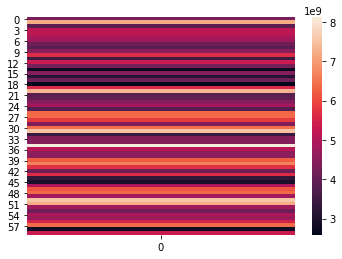

In [21]:
print(gradients_before_burnin[:D].sum())
print(gradients_before_burnin[D:].sum())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(1.8779e+13, device='cuda:0')
tensor(2.2891e+13, device='cuda:0')


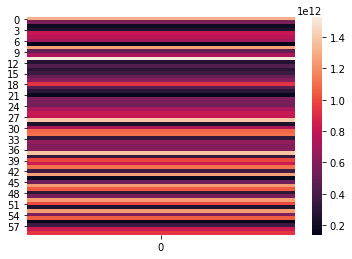

In [22]:
print(gradient_post_burn_in[:D].sum())
print(gradient_post_burn_in[D:].sum())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(11040.6406, device='cuda:0')
tensor(479.3577, device='cuda:0')


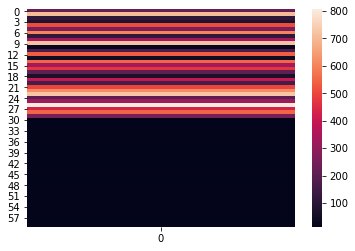

In [23]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(2878.9263, device='cuda:0')
tensor(1.0740, device='cuda:0')


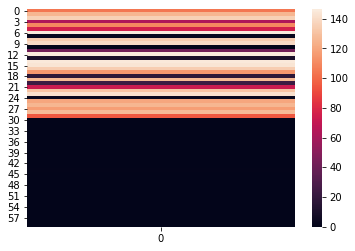

In [24]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[(D):].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [25]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(2877.8523, device='cuda:0')

The new model


In [12]:
logits_changed_loss_lambda = 0.000
vae_gumbel_truncated = VAE_Gumbel_NInstaState(2*D, 100, 20, k = 3*z_size, t = global_t, alpha = 0.3)
vae_gumbel_truncated.to(device)
vae_gumbel_trunc_optimizer = torch.optim.Adam(vae_gumbel_truncated.parameters(), 
                                                lr=lr, 
                                                betas = (b1,b2))



In [13]:
gradients_before_burnin = torch.zeros(train_data.shape[1]).to(device)
gradient_post_burn_in = torch.zeros(train_data.shape[1]).to(device)
subset_indices_before_burnin = torch.zeros(train_data.shape[1]).to(device)
subset_indices_post_burnin = torch.zeros(train_data.shape[1]).to(device)

for epoch in range(1, n_epochs+1):
    grads=train_truncated_with_gradients_gumbel_state(train_data, vae_gumbel_truncated, 
                                                      vae_gumbel_trunc_optimizer, 
                                                      epoch, 
                                                      batch_size, 
                                                      logits_changed_loss_lambda = logits_changed_loss_lambda,
                                                      Dim = 2*D, 
                                                      DEBUG = True)
    
    vae_gumbel_truncated.t = max(0.001, vae_gumbel_truncated.t * 0.99)
    if epoch <=(n_epochs//5*4):
        gradients_before_burnin += grads
        with torch.no_grad():
            subset_indices_before_burnin += sample_subset(vae_gumbel_truncated.logit_enc, 
                                                          vae_gumbel_truncated.k, 
                                                          vae_gumbel_truncated.t).view(-1)
    if epoch == (n_epochs//5*4):
        print("BURN IN DEBUG")
        vae_gumbel_truncated.set_burned_in()
        #vae_gumbel_truncated.t /= 10
        print("Going post burn in")
    if epoch > (n_epochs//5*4):
        gradient_post_burn_in += grads
        with torch.no_grad():
            subset_indices_post_burnin += sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t).view(-1)

Train Epoch: 1 [0/8000 (0%)]	Loss: 42.005844
Train Epoch: 1 [1280/8000 (16%)]	Loss: 41.402782
Train Epoch: 1 [2560/8000 (32%)]	Loss: 40.911484
Train Epoch: 1 [3840/8000 (48%)]	Loss: 40.282059
Train Epoch: 1 [5120/8000 (64%)]	Loss: 39.796371
Loss tensor(2513.2986, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(220.8560, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 1 [6400/8000 (80%)]	Loss: 39.336189
Train Epoch: 1 [7680/8000 (96%)]	Loss: 38.665920
====> Epoch: 1 Average loss: 40.2685
Train Epoch: 2 [0/8000 (0%)]	Loss: 38.464451
Train Epoch: 2 [1280/8000 (16%)]	Loss: 38.167110
Loss tensor(2417.1951, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(164.2625, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 2 [2560/8000 (32%)]	Loss: 37.332687
Train Epoch: 2 [3840/8000 (48%)]	Loss: 36.770500
Train Epoch: 2 [5120/8000 (64%)]	Loss: 36.259232
Train Epoch: 2 [6400/8000 (80%)]	Loss: 35.288357
Train Epoch: 2 [7680/8000 (96%)]	Loss: 34.702999
====> Epoch: 

Train Epoch: 14 [3840/8000 (48%)]	Loss: 32.511650
Train Epoch: 14 [5120/8000 (64%)]	Loss: 32.547626
Train Epoch: 14 [6400/8000 (80%)]	Loss: 32.698586
Train Epoch: 14 [7680/8000 (96%)]	Loss: 32.821163
====> Epoch: 14 Average loss: 32.4348
Train Epoch: 15 [0/8000 (0%)]	Loss: 32.464951
Train Epoch: 15 [1280/8000 (16%)]	Loss: 32.555840
Train Epoch: 15 [2560/8000 (32%)]	Loss: 32.122723
Train Epoch: 15 [3840/8000 (48%)]	Loss: 32.104740
Train Epoch: 15 [5120/8000 (64%)]	Loss: 32.607029
Train Epoch: 15 [6400/8000 (80%)]	Loss: 32.047745
Train Epoch: 15 [7680/8000 (96%)]	Loss: 32.426956
====> Epoch: 15 Average loss: 32.3690
Train Epoch: 16 [0/8000 (0%)]	Loss: 32.289429
Train Epoch: 16 [1280/8000 (16%)]	Loss: 32.086502
Train Epoch: 16 [2560/8000 (32%)]	Loss: 32.064129
Train Epoch: 16 [3840/8000 (48%)]	Loss: 32.184551
Train Epoch: 16 [5120/8000 (64%)]	Loss: 32.223278
Loss tensor(2078.3096, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(129.4706, device='cuda:0', grad_fn=<MseLossBackwar

Train Epoch: 30 [1280/8000 (16%)]	Loss: 31.270021
Train Epoch: 30 [2560/8000 (32%)]	Loss: 31.038166
Train Epoch: 30 [3840/8000 (48%)]	Loss: 31.017122
Train Epoch: 30 [5120/8000 (64%)]	Loss: 30.774376
Loss tensor(2020.4998, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(148.4185, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 30 [6400/8000 (80%)]	Loss: 31.288689
Loss tensor(1984.5084, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(190.2868, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 30 [7680/8000 (96%)]	Loss: 30.795158
====> Epoch: 30 Average loss: 31.0414
Train Epoch: 31 [0/8000 (0%)]	Loss: 30.970694
Train Epoch: 31 [1280/8000 (16%)]	Loss: 31.166077
Loss tensor(1976.4003, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(237.7334, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 31 [2560/8000 (32%)]	Loss: 31.055912
Loss tensor(1974.9454, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(265.8344, device='cuda:0',

Train Epoch: 43 [1280/8000 (16%)]	Loss: 30.842772
Train Epoch: 43 [2560/8000 (32%)]	Loss: 30.723131
Train Epoch: 43 [3840/8000 (48%)]	Loss: 30.644274
Train Epoch: 43 [5120/8000 (64%)]	Loss: 30.730085
Loss tensor(1958.5199, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(251.6080, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 43 [6400/8000 (80%)]	Loss: 30.616013
Train Epoch: 43 [7680/8000 (96%)]	Loss: 30.554523
====> Epoch: 43 Average loss: 30.6672
Train Epoch: 44 [0/8000 (0%)]	Loss: 30.949696
Train Epoch: 44 [1280/8000 (16%)]	Loss: 30.485756
Train Epoch: 44 [2560/8000 (32%)]	Loss: 30.780392
Train Epoch: 44 [3840/8000 (48%)]	Loss: 30.494667
Train Epoch: 44 [5120/8000 (64%)]	Loss: 30.748886
Train Epoch: 44 [6400/8000 (80%)]	Loss: 30.521086
Loss tensor(1955.7289, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(195.6216, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 44 [7680/8000 (96%)]	Loss: 30.877394
====> Epoch: 44 Average loss: 30.6627
Train 

Train Epoch: 57 [3840/8000 (48%)]	Loss: 30.695589
Train Epoch: 57 [5120/8000 (64%)]	Loss: 30.234087
Train Epoch: 57 [6400/8000 (80%)]	Loss: 30.615005
Train Epoch: 57 [7680/8000 (96%)]	Loss: 30.470768
====> Epoch: 57 Average loss: 30.5075
Train Epoch: 58 [0/8000 (0%)]	Loss: 30.653255
Train Epoch: 58 [1280/8000 (16%)]	Loss: 30.779272
Train Epoch: 58 [2560/8000 (32%)]	Loss: 30.728325
Train Epoch: 58 [3840/8000 (48%)]	Loss: 30.362715
Loss tensor(1940.4580, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(170.4417, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 58 [5120/8000 (64%)]	Loss: 30.322741
Train Epoch: 58 [6400/8000 (80%)]	Loss: 30.309069
Loss tensor(1939.0948, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(159.8261, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tensor(1951.9592, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(176.1067, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 58 [7680/8000 (96%)]	Loss: 30.667528
Loss ten

Train Epoch: 71 [3840/8000 (48%)]	Loss: 30.196198
Train Epoch: 71 [5120/8000 (64%)]	Loss: 30.120926
Train Epoch: 71 [6400/8000 (80%)]	Loss: 30.550480
Train Epoch: 71 [7680/8000 (96%)]	Loss: 30.373854
====> Epoch: 71 Average loss: 30.4077
Train Epoch: 72 [0/8000 (0%)]	Loss: 30.366392
Train Epoch: 72 [1280/8000 (16%)]	Loss: 30.574306
Train Epoch: 72 [2560/8000 (32%)]	Loss: 30.472172
Train Epoch: 72 [3840/8000 (48%)]	Loss: 30.419653
Train Epoch: 72 [5120/8000 (64%)]	Loss: 30.387482
Train Epoch: 72 [6400/8000 (80%)]	Loss: 30.178814
Train Epoch: 72 [7680/8000 (96%)]	Loss: 30.535707
====> Epoch: 72 Average loss: 30.4012
Train Epoch: 73 [0/8000 (0%)]	Loss: 30.638899
Train Epoch: 73 [1280/8000 (16%)]	Loss: 30.208000
Train Epoch: 73 [2560/8000 (32%)]	Loss: 30.358772
Train Epoch: 73 [3840/8000 (48%)]	Loss: 30.458158
Train Epoch: 73 [5120/8000 (64%)]	Loss: 30.576206
Train Epoch: 73 [6400/8000 (80%)]	Loss: 29.876762
Train Epoch: 73 [7680/8000 (96%)]	Loss: 30.305340
====> Epoch: 73 Average loss: 30

Train Epoch: 86 [3840/8000 (48%)]	Loss: 30.163019
Train Epoch: 86 [5120/8000 (64%)]	Loss: 30.310541
Train Epoch: 86 [6400/8000 (80%)]	Loss: 30.436363
Loss tensor(1950.9482, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(197.3808, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 86 [7680/8000 (96%)]	Loss: 30.250639
====> Epoch: 86 Average loss: 30.3533
Train Epoch: 87 [0/8000 (0%)]	Loss: 30.228472
Train Epoch: 87 [1280/8000 (16%)]	Loss: 30.180260
Train Epoch: 87 [2560/8000 (32%)]	Loss: 30.215904
Train Epoch: 87 [3840/8000 (48%)]	Loss: 30.339638
Loss tensor(1942.7870, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(119.9106, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 87 [5120/8000 (64%)]	Loss: 30.584284
Train Epoch: 87 [6400/8000 (80%)]	Loss: 30.558741
Train Epoch: 87 [7680/8000 (96%)]	Loss: 30.143307
====> Epoch: 87 Average loss: 30.3725
Train Epoch: 88 [0/8000 (0%)]	Loss: 30.234589
Train Epoch: 88 [1280/8000 (16%)]	Loss: 30.748762
Train Epoc

Train Epoch: 101 [1280/8000 (16%)]	Loss: 30.739885
Train Epoch: 101 [2560/8000 (32%)]	Loss: 30.345840
Train Epoch: 101 [3840/8000 (48%)]	Loss: 30.315403
Train Epoch: 101 [5120/8000 (64%)]	Loss: 30.352749
Loss tensor(1949.5724, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(178.7668, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tensor(1938.2694, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(201.9886, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 101 [6400/8000 (80%)]	Loss: 30.172316
Train Epoch: 101 [7680/8000 (96%)]	Loss: 30.231148
====> Epoch: 101 Average loss: 30.3579
Train Epoch: 102 [0/8000 (0%)]	Loss: 30.619043
Train Epoch: 102 [1280/8000 (16%)]	Loss: 30.081219
Train Epoch: 102 [2560/8000 (32%)]	Loss: 30.486780
Train Epoch: 102 [3840/8000 (48%)]	Loss: 30.604227
Train Epoch: 102 [5120/8000 (64%)]	Loss: 30.387133
Loss tensor(1937.7770, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(173.4798, device='cuda:0', grad_fn=<MseLossBackwar

Train Epoch: 116 [3840/8000 (48%)]	Loss: 30.630110
Train Epoch: 116 [5120/8000 (64%)]	Loss: 30.391560
Train Epoch: 116 [6400/8000 (80%)]	Loss: 30.291620
Train Epoch: 116 [7680/8000 (96%)]	Loss: 30.241043
====> Epoch: 116 Average loss: 30.3943
Train Epoch: 117 [0/8000 (0%)]	Loss: 30.194006
Train Epoch: 117 [1280/8000 (16%)]	Loss: 30.311546
Train Epoch: 117 [2560/8000 (32%)]	Loss: 30.121256
Train Epoch: 117 [3840/8000 (48%)]	Loss: 30.397947
Train Epoch: 117 [5120/8000 (64%)]	Loss: 30.325884
Train Epoch: 117 [6400/8000 (80%)]	Loss: 30.638393
Train Epoch: 117 [7680/8000 (96%)]	Loss: 30.229609
====> Epoch: 117 Average loss: 30.3819
Train Epoch: 118 [0/8000 (0%)]	Loss: 30.367582
Train Epoch: 118 [1280/8000 (16%)]	Loss: 30.449583
Train Epoch: 118 [2560/8000 (32%)]	Loss: 30.488567
Loss tensor(1935.1892, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(258.9839, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 118 [3840/8000 (48%)]	Loss: 30.463226
Loss tensor(1952.6401, device

Train Epoch: 131 [5120/8000 (64%)]	Loss: 30.921825
Train Epoch: 131 [6400/8000 (80%)]	Loss: 30.466309
Train Epoch: 131 [7680/8000 (96%)]	Loss: 30.251921
Loss tensor(1955.7343, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(106.5900, device='cuda:0', grad_fn=<MseLossBackward>)
====> Epoch: 131 Average loss: 30.4177
Train Epoch: 132 [0/8000 (0%)]	Loss: 30.373949
Train Epoch: 132 [1280/8000 (16%)]	Loss: 30.153965
Train Epoch: 132 [2560/8000 (32%)]	Loss: 30.226202
Train Epoch: 132 [3840/8000 (48%)]	Loss: 30.222982
Train Epoch: 132 [5120/8000 (64%)]	Loss: 30.674971
Train Epoch: 132 [6400/8000 (80%)]	Loss: 30.222811
Train Epoch: 132 [7680/8000 (96%)]	Loss: 30.259230
====> Epoch: 132 Average loss: 30.3946
Train Epoch: 133 [0/8000 (0%)]	Loss: 30.989004
Train Epoch: 133 [1280/8000 (16%)]	Loss: 30.583776
Train Epoch: 133 [2560/8000 (32%)]	Loss: 30.448032
Loss tensor(1946.4209, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(148.0135, device='cuda:0', grad_fn=<MseLossBackwa

====> Epoch: 145 Average loss: 30.4164
Train Epoch: 146 [0/8000 (0%)]	Loss: 30.375597
Train Epoch: 146 [1280/8000 (16%)]	Loss: 30.515198
Train Epoch: 146 [2560/8000 (32%)]	Loss: 30.638723
Loss tensor(1963.1163, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(175.9363, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tensor(1992.0460, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(157.7454, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 146 [3840/8000 (48%)]	Loss: 30.398924
Loss tensor(1930.5312, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(90.4482, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 146 [5120/8000 (64%)]	Loss: 30.324192
Train Epoch: 146 [6400/8000 (80%)]	Loss: 30.660172
Train Epoch: 146 [7680/8000 (96%)]	Loss: 30.483345
====> Epoch: 146 Average loss: 30.4527
Train Epoch: 147 [0/8000 (0%)]	Loss: 30.154928
Train Epoch: 147 [1280/8000 (16%)]	Loss: 30.571352
Train Epoch: 147 [2560/8000 (32%)]	Loss: 30.468908
Loss tensor(1

Train Epoch: 160 [6400/8000 (80%)]	Loss: 30.790743
Train Epoch: 160 [7680/8000 (96%)]	Loss: 30.869757
====> Epoch: 160 Average loss: 30.4904
Train Epoch: 161 [0/8000 (0%)]	Loss: 30.464340
Train Epoch: 161 [1280/8000 (16%)]	Loss: 30.668566
Train Epoch: 161 [2560/8000 (32%)]	Loss: 30.730602
Train Epoch: 161 [3840/8000 (48%)]	Loss: 30.225607
Train Epoch: 161 [5120/8000 (64%)]	Loss: 30.291374
Train Epoch: 161 [6400/8000 (80%)]	Loss: 30.232306
Loss tensor(1955.5890, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(289.1620, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 161 [7680/8000 (96%)]	Loss: 30.326797
====> Epoch: 161 Average loss: 30.4944
Train Epoch: 162 [0/8000 (0%)]	Loss: 30.119059
Train Epoch: 162 [1280/8000 (16%)]	Loss: 30.003960
Train Epoch: 162 [2560/8000 (32%)]	Loss: 30.597612
Train Epoch: 162 [3840/8000 (48%)]	Loss: 30.301342
Train Epoch: 162 [5120/8000 (64%)]	Loss: 30.544859
Train Epoch: 162 [6400/8000 (80%)]	Loss: 30.698799
Train Epoch: 162 [7680/8000 (

Train Epoch: 175 [1280/8000 (16%)]	Loss: 30.491556
Loss tensor(1929.8527, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(164.3323, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 175 [2560/8000 (32%)]	Loss: 30.153948
Train Epoch: 175 [3840/8000 (48%)]	Loss: 30.839266
Train Epoch: 175 [5120/8000 (64%)]	Loss: 30.398790
Loss tensor(1944.7992, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(118.8739, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 175 [6400/8000 (80%)]	Loss: 30.933931
Train Epoch: 175 [7680/8000 (96%)]	Loss: 30.401094
====> Epoch: 175 Average loss: 30.5523
Train Epoch: 176 [0/8000 (0%)]	Loss: 30.630688
Train Epoch: 176 [1280/8000 (16%)]	Loss: 30.343615
Train Epoch: 176 [2560/8000 (32%)]	Loss: 30.543852
Train Epoch: 176 [3840/8000 (48%)]	Loss: 31.145035
Train Epoch: 176 [5120/8000 (64%)]	Loss: 30.436270
Train Epoch: 176 [6400/8000 (80%)]	Loss: 30.630358
Loss tensor(1950.8871, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor

Train Epoch: 190 [1280/8000 (16%)]	Loss: 30.166298
Train Epoch: 190 [2560/8000 (32%)]	Loss: 30.729675
Loss tensor(1985.2716, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(132.5851, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 190 [3840/8000 (48%)]	Loss: 30.770872
Loss tensor(1963.0758, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(167.7784, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 190 [5120/8000 (64%)]	Loss: 30.382071
Train Epoch: 190 [6400/8000 (80%)]	Loss: 30.598177
Train Epoch: 190 [7680/8000 (96%)]	Loss: 30.320257
====> Epoch: 190 Average loss: 30.5864
Train Epoch: 191 [0/8000 (0%)]	Loss: 30.469976
Train Epoch: 191 [1280/8000 (16%)]	Loss: 30.607710
Train Epoch: 191 [2560/8000 (32%)]	Loss: 30.772282
Train Epoch: 191 [3840/8000 (48%)]	Loss: 30.276226
Train Epoch: 191 [5120/8000 (64%)]	Loss: 30.735575
Train Epoch: 191 [6400/8000 (80%)]	Loss: 30.347073
Train Epoch: 191 [7680/8000 (96%)]	Loss: 30.566113
Loss tensor(1957.3333, device=

Train Epoch: 203 [7680/8000 (96%)]	Loss: 30.611885
====> Epoch: 203 Average loss: 30.6229
Train Epoch: 204 [0/8000 (0%)]	Loss: 31.124954
Train Epoch: 204 [1280/8000 (16%)]	Loss: 30.389425
Train Epoch: 204 [2560/8000 (32%)]	Loss: 30.591137
Train Epoch: 204 [3840/8000 (48%)]	Loss: 30.476797
Train Epoch: 204 [5120/8000 (64%)]	Loss: 30.932869
Train Epoch: 204 [6400/8000 (80%)]	Loss: 30.539625
Train Epoch: 204 [7680/8000 (96%)]	Loss: 30.581266
====> Epoch: 204 Average loss: 30.6217
Train Epoch: 205 [0/8000 (0%)]	Loss: 30.479855
Loss tensor(1952.2987, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(166.2174, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tensor(1970.0665, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(179.5011, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 205 [1280/8000 (16%)]	Loss: 30.399147
Train Epoch: 205 [2560/8000 (32%)]	Loss: 30.378820
Train Epoch: 205 [3840/8000 (48%)]	Loss: 31.154388
Loss tensor(1927.8257, device='cuda:0', grad_f

Train Epoch: 218 [5120/8000 (64%)]	Loss: 30.717867
Train Epoch: 218 [6400/8000 (80%)]	Loss: 30.431566
Train Epoch: 218 [7680/8000 (96%)]	Loss: 30.591064
====> Epoch: 218 Average loss: 30.6277
Train Epoch: 219 [0/8000 (0%)]	Loss: 30.722404
Train Epoch: 219 [1280/8000 (16%)]	Loss: 30.591156
Train Epoch: 219 [2560/8000 (32%)]	Loss: 30.247120
Train Epoch: 219 [3840/8000 (48%)]	Loss: 30.269558
Train Epoch: 219 [5120/8000 (64%)]	Loss: 30.683647
Train Epoch: 219 [6400/8000 (80%)]	Loss: 30.670815
Train Epoch: 219 [7680/8000 (96%)]	Loss: 30.778414
====> Epoch: 219 Average loss: 30.6481
Train Epoch: 220 [0/8000 (0%)]	Loss: 30.560202
Train Epoch: 220 [1280/8000 (16%)]	Loss: 30.193647
Train Epoch: 220 [2560/8000 (32%)]	Loss: 30.491888
Train Epoch: 220 [3840/8000 (48%)]	Loss: 30.677446
Loss tensor(1957.4595, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(121.1950, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 220 [5120/8000 (64%)]	Loss: 30.448742
Loss tensor(1968.0864, device

Loss tensor(1974.7372, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(167.0915, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 232 [1280/8000 (16%)]	Loss: 30.237768
Loss tensor(1966.6774, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(153.4945, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 232 [2560/8000 (32%)]	Loss: 31.235739
Loss tensor(1966.7224, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(149.1562, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 232 [3840/8000 (48%)]	Loss: 30.730038
Train Epoch: 232 [5120/8000 (64%)]	Loss: 31.056993
Train Epoch: 232 [6400/8000 (80%)]	Loss: 30.531523
Loss tensor(1945.5906, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(161.3795, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 232 [7680/8000 (96%)]	Loss: 30.985056
====> Epoch: 232 Average loss: 30.6969
Train Epoch: 233 [0/8000 (0%)]	Loss: 30.737984
Train Epoch: 233 [1280/8000 (16%)]	Loss: 30.374043
Train Epoch: 

Loss tensor(1980.3845, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(177.7428, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 247 [1280/8000 (16%)]	Loss: 30.417049
Train Epoch: 247 [2560/8000 (32%)]	Loss: 31.035509
Loss tensor(1950.1661, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(166.6793, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 247 [3840/8000 (48%)]	Loss: 30.642179
Train Epoch: 247 [5120/8000 (64%)]	Loss: 30.681583
Train Epoch: 247 [6400/8000 (80%)]	Loss: 30.243223
Loss tensor(1963.2629, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(147.5366, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 247 [7680/8000 (96%)]	Loss: 30.124474
====> Epoch: 247 Average loss: 30.6495
Train Epoch: 248 [0/8000 (0%)]	Loss: 30.807360
Loss tensor(1959.4689, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(217.0253, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 248 [1280/8000 (16%)]	Loss: 30.817568
Train Epoch: 

Train Epoch: 261 [1280/8000 (16%)]	Loss: 30.906136
Loss tensor(1962.7354, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(175.2497, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 261 [2560/8000 (32%)]	Loss: 30.687660
Train Epoch: 261 [3840/8000 (48%)]	Loss: 31.348940
Loss tensor(1974.8237, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(214.8670, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 261 [5120/8000 (64%)]	Loss: 30.417231
Loss tensor(1967.7847, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(145.8608, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 261 [6400/8000 (80%)]	Loss: 31.384550
Loss tensor(1957.4833, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(175.8516, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 261 [7680/8000 (96%)]	Loss: 30.828690
====> Epoch: 261 Average loss: 30.7179
Train Epoch: 262 [0/8000 (0%)]	Loss: 30.705610
Loss tensor(1946.4429, device='cuda:0', grad_fn=<AddBackward0>)L

Train Epoch: 275 [1280/8000 (16%)]	Loss: 30.575474
Loss tensor(1980.6088, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(206.4773, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 275 [2560/8000 (32%)]	Loss: 31.195772
Train Epoch: 275 [3840/8000 (48%)]	Loss: 30.479055
Train Epoch: 275 [5120/8000 (64%)]	Loss: 30.769489
Train Epoch: 275 [6400/8000 (80%)]	Loss: 31.269602
Train Epoch: 275 [7680/8000 (96%)]	Loss: 30.825531
====> Epoch: 275 Average loss: 30.7384
Train Epoch: 276 [0/8000 (0%)]	Loss: 31.115978
Train Epoch: 276 [1280/8000 (16%)]	Loss: 30.265297
Loss tensor(1952.1738, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(142.0638, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tensor(1977.9691, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(165.5075, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 276 [2560/8000 (32%)]	Loss: 30.470642
Train Epoch: 276 [3840/8000 (48%)]	Loss: 30.766710
Loss tensor(1959.9987, device='cuda:0', grad_fn

Train Epoch: 290 [1280/8000 (16%)]	Loss: 31.035658
Train Epoch: 290 [2560/8000 (32%)]	Loss: 30.764765
Train Epoch: 290 [3840/8000 (48%)]	Loss: 30.667849
Loss tensor(1979.5146, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(187.2419, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 290 [5120/8000 (64%)]	Loss: 30.583576
Loss tensor(1977.9634, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(203.7449, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 290 [6400/8000 (80%)]	Loss: 30.581959
Loss tensor(1996.1809, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(195.7761, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 290 [7680/8000 (96%)]	Loss: 30.834785
====> Epoch: 290 Average loss: 30.7346
Train Epoch: 291 [0/8000 (0%)]	Loss: 30.515026
Train Epoch: 291 [1280/8000 (16%)]	Loss: 30.756405
Train Epoch: 291 [2560/8000 (32%)]	Loss: 30.990677
Loss tensor(1964.9138, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(191.9827, device

Train Epoch: 304 [3840/8000 (48%)]	Loss: 30.786757
Train Epoch: 304 [5120/8000 (64%)]	Loss: 30.535133
Loss tensor(1958.5425, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(139.8280, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 304 [6400/8000 (80%)]	Loss: 31.009562
Train Epoch: 304 [7680/8000 (96%)]	Loss: 30.605083
====> Epoch: 304 Average loss: 30.7614
Train Epoch: 305 [0/8000 (0%)]	Loss: 31.338285
Train Epoch: 305 [1280/8000 (16%)]	Loss: 30.733070
Train Epoch: 305 [2560/8000 (32%)]	Loss: 30.395908
Train Epoch: 305 [3840/8000 (48%)]	Loss: 30.383200
Train Epoch: 305 [5120/8000 (64%)]	Loss: 30.489111
Loss tensor(1961.7554, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(232.9836, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 305 [6400/8000 (80%)]	Loss: 31.166809
Train Epoch: 305 [7680/8000 (96%)]	Loss: 30.630308
====> Epoch: 305 Average loss: 30.7711
Train Epoch: 306 [0/8000 (0%)]	Loss: 30.685282
Train Epoch: 306 [1280/8000 (16%)]	Loss: 30.85

Loss tensor(1971.1400, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(108.4205, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 319 [6400/8000 (80%)]	Loss: 30.705294
Loss tensor(1966.4526, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(105.2848, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 319 [7680/8000 (96%)]	Loss: 31.374563
====> Epoch: 319 Average loss: 30.7894
Train Epoch: 320 [0/8000 (0%)]	Loss: 30.712658
Train Epoch: 320 [1280/8000 (16%)]	Loss: 30.650461
Train Epoch: 320 [2560/8000 (32%)]	Loss: 30.974722
Train Epoch: 320 [3840/8000 (48%)]	Loss: 32.223854
Loss tensor(1951.9727, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(161.2189, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 320 [5120/8000 (64%)]	Loss: 30.496136
Train Epoch: 320 [6400/8000 (80%)]	Loss: 31.122112
Loss tensor(1942.8014, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(153.4726, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 

Train Epoch: 334 [1280/8000 (16%)]	Loss: 30.429049
Train Epoch: 334 [2560/8000 (32%)]	Loss: 30.592934
Train Epoch: 334 [3840/8000 (48%)]	Loss: 30.643377
Train Epoch: 334 [5120/8000 (64%)]	Loss: 30.915485
Train Epoch: 334 [6400/8000 (80%)]	Loss: 30.597813
Train Epoch: 334 [7680/8000 (96%)]	Loss: 30.735640
====> Epoch: 334 Average loss: 30.7634
Train Epoch: 335 [0/8000 (0%)]	Loss: 30.634457
Train Epoch: 335 [1280/8000 (16%)]	Loss: 30.676756
Train Epoch: 335 [2560/8000 (32%)]	Loss: 30.745937
Train Epoch: 335 [3840/8000 (48%)]	Loss: 30.557308
Loss tensor(1966.7330, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(166.0086, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 335 [5120/8000 (64%)]	Loss: 31.095415
Train Epoch: 335 [6400/8000 (80%)]	Loss: 30.742659
Loss tensor(1955.7397, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(213.0332, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 335 [7680/8000 (96%)]	Loss: 30.759871
====> Epoch: 335 Average loss:

Train Epoch: 349 [2560/8000 (32%)]	Loss: 30.580139
Train Epoch: 349 [3840/8000 (48%)]	Loss: 30.641701
Train Epoch: 349 [5120/8000 (64%)]	Loss: 30.483549
Train Epoch: 349 [6400/8000 (80%)]	Loss: 30.305054
Train Epoch: 349 [7680/8000 (96%)]	Loss: 30.827312
====> Epoch: 349 Average loss: 30.7685
Train Epoch: 350 [0/8000 (0%)]	Loss: 30.626410
Train Epoch: 350 [1280/8000 (16%)]	Loss: 31.032434
Train Epoch: 350 [2560/8000 (32%)]	Loss: 30.580030
Train Epoch: 350 [3840/8000 (48%)]	Loss: 30.722246
Train Epoch: 350 [5120/8000 (64%)]	Loss: 30.349325
Train Epoch: 350 [6400/8000 (80%)]	Loss: 31.277632
Train Epoch: 350 [7680/8000 (96%)]	Loss: 30.943369
Loss tensor(2002.1057, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(196.8728, device='cuda:0', grad_fn=<MseLossBackward>)
====> Epoch: 350 Average loss: 30.7145
Train Epoch: 351 [0/8000 (0%)]	Loss: 30.987692
Train Epoch: 351 [1280/8000 (16%)]	Loss: 30.667946
Loss tensor(1992.1989, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tenso

Train Epoch: 365 [1280/8000 (16%)]	Loss: 30.340729
Train Epoch: 365 [2560/8000 (32%)]	Loss: 30.342398
Train Epoch: 365 [3840/8000 (48%)]	Loss: 30.591173
Train Epoch: 365 [5120/8000 (64%)]	Loss: 31.189861
Loss tensor(2000.2478, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(141.7315, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 365 [6400/8000 (80%)]	Loss: 30.885010
Loss tensor(1981.7407, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(121.0506, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 365 [7680/8000 (96%)]	Loss: 30.020258
====> Epoch: 365 Average loss: 30.7493
Train Epoch: 366 [0/8000 (0%)]	Loss: 30.499018
Train Epoch: 366 [1280/8000 (16%)]	Loss: 31.217340
Train Epoch: 366 [2560/8000 (32%)]	Loss: 30.688185
Loss tensor(1989.5449, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(208.7170, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 366 [3840/8000 (48%)]	Loss: 30.555050
Loss tensor(1969.9105, device='cuda:0', grad_fn

Train Epoch: 377 [7680/8000 (96%)]	Loss: 30.996815
====> Epoch: 377 Average loss: 30.7446
Train Epoch: 378 [0/8000 (0%)]	Loss: 31.845697
Train Epoch: 378 [1280/8000 (16%)]	Loss: 30.755716
Loss tensor(1937.8127, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(138.6413, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tensor(1948.5693, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(112.4182, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 378 [2560/8000 (32%)]	Loss: 31.203850
Train Epoch: 378 [3840/8000 (48%)]	Loss: 31.249668
Train Epoch: 378 [5120/8000 (64%)]	Loss: 30.674944
Train Epoch: 378 [6400/8000 (80%)]	Loss: 30.846609
Train Epoch: 378 [7680/8000 (96%)]	Loss: 31.091427
====> Epoch: 378 Average loss: 30.7632
Train Epoch: 379 [0/8000 (0%)]	Loss: 30.828897
Loss tensor(1968.8684, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(114.7099, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 379 [1280/8000 (16%)]	Loss: 30.763569
Train Epoch:

Train Epoch: 391 [3840/8000 (48%)]	Loss: 30.113899
Train Epoch: 391 [5120/8000 (64%)]	Loss: 30.840431
Train Epoch: 391 [6400/8000 (80%)]	Loss: 30.479082
Train Epoch: 391 [7680/8000 (96%)]	Loss: 30.594284
Loss tensor(2019.6525, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(184.7687, device='cuda:0', grad_fn=<MseLossBackward>)
====> Epoch: 391 Average loss: 30.7323
Train Epoch: 392 [0/8000 (0%)]	Loss: 30.609926
Train Epoch: 392 [1280/8000 (16%)]	Loss: 30.361565
Train Epoch: 392 [2560/8000 (32%)]	Loss: 30.476400
Train Epoch: 392 [3840/8000 (48%)]	Loss: 31.300564
Train Epoch: 392 [5120/8000 (64%)]	Loss: 30.933796
Train Epoch: 392 [6400/8000 (80%)]	Loss: 30.725569
Train Epoch: 392 [7680/8000 (96%)]	Loss: 30.905560
====> Epoch: 392 Average loss: 30.8209
Loss tensor(1997.3752, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(447.2187, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 393 [0/8000 (0%)]	Loss: 31.208988
Train Epoch: 393 [1280/8000 (16%)]	Loss: 30.62

Train Epoch: 405 [1280/8000 (16%)]	Loss: 30.434879
Train Epoch: 405 [2560/8000 (32%)]	Loss: 30.567490
Train Epoch: 405 [3840/8000 (48%)]	Loss: 30.564289
Train Epoch: 405 [5120/8000 (64%)]	Loss: 30.303051
Loss tensor(1948.7001, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(201.0118, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tensor(1945.2885, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(196.9306, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 405 [6400/8000 (80%)]	Loss: 31.265512
Train Epoch: 405 [7680/8000 (96%)]	Loss: 30.615398
====> Epoch: 405 Average loss: 30.6939
Train Epoch: 406 [0/8000 (0%)]	Loss: 30.522829
Train Epoch: 406 [1280/8000 (16%)]	Loss: 30.613779
Train Epoch: 406 [2560/8000 (32%)]	Loss: 30.788147
Train Epoch: 406 [3840/8000 (48%)]	Loss: 30.669970
Train Epoch: 406 [5120/8000 (64%)]	Loss: 30.528252
Loss tensor(1950.5924, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(320.0796, device='cuda:0', grad_fn=<MseLossBackwar

Train Epoch: 421 [1280/8000 (16%)]	Loss: 30.372665
Train Epoch: 421 [2560/8000 (32%)]	Loss: 31.035933
Loss tensor(1964.1875, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(178.6833, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 421 [3840/8000 (48%)]	Loss: 31.001621
Train Epoch: 421 [5120/8000 (64%)]	Loss: 30.647764
Train Epoch: 421 [6400/8000 (80%)]	Loss: 30.455366
Train Epoch: 421 [7680/8000 (96%)]	Loss: 30.803635
====> Epoch: 421 Average loss: 30.7337
Train Epoch: 422 [0/8000 (0%)]	Loss: 30.538977
Train Epoch: 422 [1280/8000 (16%)]	Loss: 30.812613
Loss tensor(1977.7252, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(98.6818, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 422 [2560/8000 (32%)]	Loss: 30.392433
Train Epoch: 422 [3840/8000 (48%)]	Loss: 30.846462
Train Epoch: 422 [5120/8000 (64%)]	Loss: 30.809925
Train Epoch: 422 [6400/8000 (80%)]	Loss: 30.882767
Train Epoch: 422 [7680/8000 (96%)]	Loss: 30.516846
====> Epoch: 422 Average loss: 

Train Epoch: 435 [1280/8000 (16%)]	Loss: 30.573486
Train Epoch: 435 [2560/8000 (32%)]	Loss: 30.971581
Train Epoch: 435 [3840/8000 (48%)]	Loss: 30.897652
Train Epoch: 435 [5120/8000 (64%)]	Loss: 30.416418
Train Epoch: 435 [6400/8000 (80%)]	Loss: 30.941345
Train Epoch: 435 [7680/8000 (96%)]	Loss: 30.772987
====> Epoch: 435 Average loss: 30.7811
Train Epoch: 436 [0/8000 (0%)]	Loss: 30.769154
Train Epoch: 436 [1280/8000 (16%)]	Loss: 31.562603
Train Epoch: 436 [2560/8000 (32%)]	Loss: 31.151974
Train Epoch: 436 [3840/8000 (48%)]	Loss: 30.738371
Train Epoch: 436 [5120/8000 (64%)]	Loss: 30.546379
Train Epoch: 436 [6400/8000 (80%)]	Loss: 30.866976
Train Epoch: 436 [7680/8000 (96%)]	Loss: 31.171186
====> Epoch: 436 Average loss: 30.7331
Train Epoch: 437 [0/8000 (0%)]	Loss: 31.096016
Train Epoch: 437 [1280/8000 (16%)]	Loss: 30.678493
Train Epoch: 437 [2560/8000 (32%)]	Loss: 30.929306
Train Epoch: 437 [3840/8000 (48%)]	Loss: 30.962421
Train Epoch: 437 [5120/8000 (64%)]	Loss: 31.105949
Train Epoch:

Train Epoch: 449 [1280/8000 (16%)]	Loss: 30.670570
Loss tensor(1965.0989, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(232.5825, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 449 [2560/8000 (32%)]	Loss: 30.924490
Train Epoch: 449 [3840/8000 (48%)]	Loss: 30.711329
Train Epoch: 449 [5120/8000 (64%)]	Loss: 31.218239
Train Epoch: 449 [6400/8000 (80%)]	Loss: 30.782187
Train Epoch: 449 [7680/8000 (96%)]	Loss: 30.534082
====> Epoch: 449 Average loss: 30.6928
Train Epoch: 450 [0/8000 (0%)]	Loss: 31.295450
Train Epoch: 450 [1280/8000 (16%)]	Loss: 30.744946
Train Epoch: 450 [2560/8000 (32%)]	Loss: 30.839947
Loss tensor(1995.2877, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(233.6763, device='cuda:0', grad_fn=<MseLossBackward>)
Loss tensor(2014.0299, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(396.0176, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 450 [3840/8000 (48%)]	Loss: 30.938993
Loss tensor(1953.8490, device='cuda:0', grad_fn

Train Epoch: 463 [1280/8000 (16%)]	Loss: 30.809664
Train Epoch: 463 [2560/8000 (32%)]	Loss: 31.414810
Train Epoch: 463 [3840/8000 (48%)]	Loss: 30.952286
Train Epoch: 463 [5120/8000 (64%)]	Loss: 30.583677
Train Epoch: 463 [6400/8000 (80%)]	Loss: 31.571953
Loss tensor(1995.9028, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(260.9393, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 463 [7680/8000 (96%)]	Loss: 30.820770
Loss tensor(1990.2186, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(203.4168, device='cuda:0', grad_fn=<MseLossBackward>)
====> Epoch: 463 Average loss: 30.7253
Train Epoch: 464 [0/8000 (0%)]	Loss: 30.618452
Loss tensor(1945.9849, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(332.2326, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 464 [1280/8000 (16%)]	Loss: 30.406059
Train Epoch: 464 [2560/8000 (32%)]	Loss: 32.146656
Train Epoch: 464 [3840/8000 (48%)]	Loss: 30.694273
Train Epoch: 464 [5120/8000 (64%)]	Loss: 30.588

Train Epoch: 477 [1280/8000 (16%)]	Loss: 30.568090
Loss tensor(1964.5533, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(204.5694, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 477 [2560/8000 (32%)]	Loss: 30.259014
Train Epoch: 477 [3840/8000 (48%)]	Loss: 31.210266
Train Epoch: 477 [5120/8000 (64%)]	Loss: 30.759304
Train Epoch: 477 [6400/8000 (80%)]	Loss: 31.519369
Loss tensor(1958.4679, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(337.4799, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 477 [7680/8000 (96%)]	Loss: 30.629192
====> Epoch: 477 Average loss: 30.6852
Train Epoch: 478 [0/8000 (0%)]	Loss: 30.401083
Loss tensor(1948.2781, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss tensor(341.5399, device='cuda:0', grad_fn=<MseLossBackward>)
Train Epoch: 478 [1280/8000 (16%)]	Loss: 30.441845
Train Epoch: 478 [2560/8000 (32%)]	Loss: 30.534586
Train Epoch: 478 [3840/8000 (48%)]	Loss: 32.070595
Train Epoch: 478 [5120/8000 (64%)]	Loss: 31.042

Train Epoch: 492 [6400/8000 (80%)]	Loss: 31.112173
Train Epoch: 492 [7680/8000 (96%)]	Loss: 31.985483
====> Epoch: 492 Average loss: 31.0175
Train Epoch: 493 [0/8000 (0%)]	Loss: 31.251215
Train Epoch: 493 [1280/8000 (16%)]	Loss: 30.913744
Train Epoch: 493 [2560/8000 (32%)]	Loss: 31.469299
Loss tensor(2018.2169, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 493 [3840/8000 (48%)]	Loss: 30.632507
Train Epoch: 493 [5120/8000 (64%)]	Loss: 31.042114
Loss tensor(1947.9025, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 493 [6400/8000 (80%)]	Loss: 30.825560
Train Epoch: 493 [7680/8000 (96%)]	Loss: 32.011272
====> Epoch: 493 Average loss: 30.9174
Train Epoch: 494 [0/8000 (0%)]	Loss: 31.826832
Loss tensor(1970.2419, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 494 [1280/8000 (16%)]	Loss: 30.942917
Train Epoch: 494 [2560/8000 (32%)]	Loss: 30.984743
Train Epoch: 494 [3840/8000 (48%)]	Loss: 31.045099
Train Epoch: 494 [5120/8000 (64%)]	L

Train Epoch: 509 [2560/8000 (32%)]	Loss: 32.365726
Train Epoch: 509 [3840/8000 (48%)]	Loss: 30.987152
Loss tensor(1995.1696, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 509 [5120/8000 (64%)]	Loss: 30.790560
Train Epoch: 509 [6400/8000 (80%)]	Loss: 30.695740
Train Epoch: 509 [7680/8000 (96%)]	Loss: 31.166288
====> Epoch: 509 Average loss: 31.1351
Train Epoch: 510 [0/8000 (0%)]	Loss: 30.933661
Train Epoch: 510 [1280/8000 (16%)]	Loss: 30.703527
Train Epoch: 510 [2560/8000 (32%)]	Loss: 31.182762
Train Epoch: 510 [3840/8000 (48%)]	Loss: 31.498362
Loss tensor(2011.3838, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 510 [5120/8000 (64%)]	Loss: 31.104097
Train Epoch: 510 [6400/8000 (80%)]	Loss: 30.962542
Train Epoch: 510 [7680/8000 (96%)]	Loss: 30.840693
====> Epoch: 510 Average loss: 31.0784
Train Epoch: 511 [0/8000 (0%)]	Loss: 31.003029
Train Epoch: 511 [1280/8000 (16%)]	Loss: 30.631149
Train Epoch: 511 [2560/8000 (32%)]	Loss: 30.543991
Train Epoch

Train Epoch: 527 [5120/8000 (64%)]	Loss: 31.139412
Train Epoch: 527 [6400/8000 (80%)]	Loss: 31.053616
Train Epoch: 527 [7680/8000 (96%)]	Loss: 31.216835
====> Epoch: 527 Average loss: 31.1348
Train Epoch: 528 [0/8000 (0%)]	Loss: 30.732477
Train Epoch: 528 [1280/8000 (16%)]	Loss: 30.720818
Train Epoch: 528 [2560/8000 (32%)]	Loss: 31.066881
Train Epoch: 528 [3840/8000 (48%)]	Loss: 31.055136
Train Epoch: 528 [5120/8000 (64%)]	Loss: 31.011072
Train Epoch: 528 [6400/8000 (80%)]	Loss: 30.741352
Train Epoch: 528 [7680/8000 (96%)]	Loss: 30.441742
====> Epoch: 528 Average loss: 31.1067
Train Epoch: 529 [0/8000 (0%)]	Loss: 31.551064
Train Epoch: 529 [1280/8000 (16%)]	Loss: 30.495426
Train Epoch: 529 [2560/8000 (32%)]	Loss: 30.511168
Train Epoch: 529 [3840/8000 (48%)]	Loss: 31.128267
Train Epoch: 529 [5120/8000 (64%)]	Loss: 32.516087
Train Epoch: 529 [6400/8000 (80%)]	Loss: 31.027508
Train Epoch: 529 [7680/8000 (96%)]	Loss: 30.848381
====> Epoch: 529 Average loss: 31.0768
Train Epoch: 530 [0/8000

Train Epoch: 544 [5120/8000 (64%)]	Loss: 31.282301
Train Epoch: 544 [6400/8000 (80%)]	Loss: 30.907248
Loss tensor(1967.9691, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 544 [7680/8000 (96%)]	Loss: 30.729538
====> Epoch: 544 Average loss: 31.0559
Train Epoch: 545 [0/8000 (0%)]	Loss: 31.066843
Train Epoch: 545 [1280/8000 (16%)]	Loss: 30.771904
Train Epoch: 545 [2560/8000 (32%)]	Loss: 30.972260
Loss tensor(1972.6910, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 545 [3840/8000 (48%)]	Loss: 30.804417
Train Epoch: 545 [5120/8000 (64%)]	Loss: 31.110430
Loss tensor(1967.5750, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 545 [6400/8000 (80%)]	Loss: 30.998804
Train Epoch: 545 [7680/8000 (96%)]	Loss: 31.059675
====> Epoch: 545 Average loss: 30.9639
Train Epoch: 546 [0/8000 (0%)]	Loss: 31.098680
Train Epoch: 546 [1280/8000 (16%)]	Loss: 32.020851
Train Epoch: 546 [2560/8000 (32%)]	Loss: 30.947706
Train Epoch: 546 [3840/8000 (48%)]	L

Train Epoch: 561 [1280/8000 (16%)]	Loss: 31.100157
Train Epoch: 561 [2560/8000 (32%)]	Loss: 30.420820
Loss tensor(1959.0388, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 561 [3840/8000 (48%)]	Loss: 31.290422
Train Epoch: 561 [5120/8000 (64%)]	Loss: 30.898268
Train Epoch: 561 [6400/8000 (80%)]	Loss: 31.230255
Train Epoch: 561 [7680/8000 (96%)]	Loss: 30.551525
====> Epoch: 561 Average loss: 31.1108
Train Epoch: 562 [0/8000 (0%)]	Loss: 30.743446
Loss tensor(2047.2418, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 562 [1280/8000 (16%)]	Loss: 31.012774
Train Epoch: 562 [2560/8000 (32%)]	Loss: 30.392603
Train Epoch: 562 [3840/8000 (48%)]	Loss: 31.680279
Train Epoch: 562 [5120/8000 (64%)]	Loss: 31.754814
Loss tensor(1969.9950, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 562 [6400/8000 (80%)]	Loss: 30.705236
Train Epoch: 562 [7680/8000 (96%)]	Loss: 30.699663
====> Epoch: 562 Average loss: 31.0623
Train Epoch: 563 [0/8000 (0%)]	L

Train Epoch: 578 [7680/8000 (96%)]	Loss: 31.721434
====> Epoch: 578 Average loss: 30.9488
Train Epoch: 579 [0/8000 (0%)]	Loss: 31.020626
Train Epoch: 579 [1280/8000 (16%)]	Loss: 30.803930
Train Epoch: 579 [2560/8000 (32%)]	Loss: 31.444614
Loss tensor(2070.9956, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 579 [3840/8000 (48%)]	Loss: 32.445869
Train Epoch: 579 [5120/8000 (64%)]	Loss: 30.679857
Train Epoch: 579 [6400/8000 (80%)]	Loss: 30.650957
Train Epoch: 579 [7680/8000 (96%)]	Loss: 30.687571
Loss tensor(1981.7645, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
====> Epoch: 579 Average loss: 31.0279
Train Epoch: 580 [0/8000 (0%)]	Loss: 30.657436
Train Epoch: 580 [1280/8000 (16%)]	Loss: 30.926485
Train Epoch: 580 [2560/8000 (32%)]	Loss: 30.986996
Train Epoch: 580 [3840/8000 (48%)]	Loss: 31.009666
Train Epoch: 580 [5120/8000 (64%)]	Loss: 33.333557
Train Epoch: 580 [6400/8000 (80%)]	Loss: 30.834858
Train Epoch: 580 [7680/8000 (96%)]	Loss: 30.737289
====> Epoch

Train Epoch: 595 [3840/8000 (48%)]	Loss: 30.495451
Train Epoch: 595 [5120/8000 (64%)]	Loss: 31.121222
Train Epoch: 595 [6400/8000 (80%)]	Loss: 31.238295
Loss tensor(1982.7262, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 595 [7680/8000 (96%)]	Loss: 30.689480
====> Epoch: 595 Average loss: 31.2069
Train Epoch: 596 [0/8000 (0%)]	Loss: 30.754562
Train Epoch: 596 [1280/8000 (16%)]	Loss: 30.968058
Train Epoch: 596 [2560/8000 (32%)]	Loss: 31.720140
Train Epoch: 596 [3840/8000 (48%)]	Loss: 31.351515
Loss tensor(1999.9053, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 596 [5120/8000 (64%)]	Loss: 32.159599
Train Epoch: 596 [6400/8000 (80%)]	Loss: 31.192024
Loss tensor(2055.2939, device='cuda:0', grad_fn=<AddBackward0>)Logits Loss 0
Train Epoch: 596 [7680/8000 (96%)]	Loss: 30.692045
====> Epoch: 596 Average loss: 31.0723
Train Epoch: 597 [0/8000 (0%)]	Loss: 31.256529
Train Epoch: 597 [1280/8000 (16%)]	Loss: 30.842386
Train Epoch: 597 [2560/8000 (32%)]	L

tensor(2198357.7500, device='cuda:0')
tensor(128234.5938, device='cuda:0')


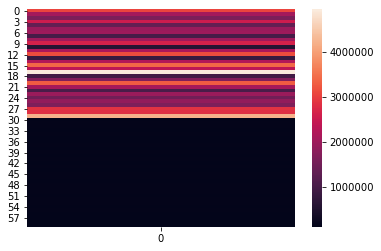

In [14]:
print(gradients_before_burnin[:(D)].mean())
print(gradients_before_burnin[(D):].mean())
sns.heatmap(gradients_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])


tensor(737843.4375, device='cuda:0')
tensor(34539.7930, device='cuda:0')


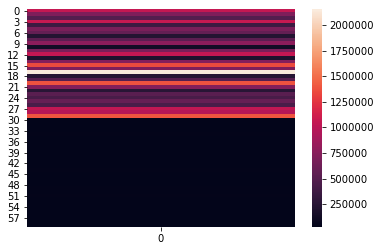

In [15]:
print(gradient_post_burn_in[:D].mean())
print(gradient_post_burn_in[D:].mean())
sns.heatmap(gradient_post_burn_in.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(5738.9380, device='cuda:0')
tensor(5781.0615, device='cuda:0')


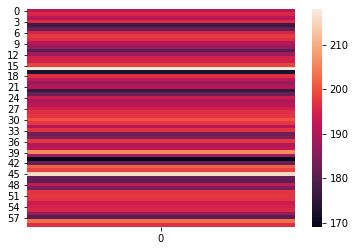

In [16]:
print(subset_indices_before_burnin[:D].sum())
print(subset_indices_before_burnin[D:].sum())
sns.heatmap(subset_indices_before_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

tensor(1421.5598, device='cuda:0')
tensor(1458.4403, device='cuda:0')


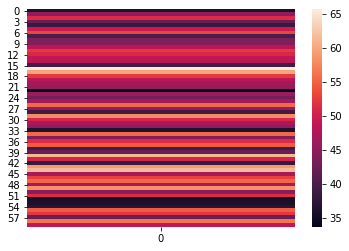

In [17]:
print(subset_indices_post_burnin[:D].sum())
print(subset_indices_post_burnin[D:].sum())
sns.heatmap(subset_indices_post_burnin.clone().detach().cpu().numpy()[:, np.newaxis])

In [18]:
subset_indices_post_burnin[:(D)]

tensor([36.1155, 45.4265, 51.3741, 42.4464, 38.5256, 49.6306, 53.3748, 40.0779,
        43.9301, 44.3042, 48.4420, 52.5437, 51.1724, 48.8783, 48.5995, 39.4536,
        65.6565, 59.8512, 52.3781, 48.6147, 46.7067, 45.8434, 33.7189, 46.1941,
        43.1994, 46.6396, 55.6056, 45.6084, 39.2562, 57.9916], device='cuda:0')

In [19]:
subset_indices_post_burnin[(D):]

tensor([50.8316, 47.0415, 45.4099, 36.3339, 55.6484, 44.4080, 51.3968, 54.6228,
        39.4924, 42.0563, 61.3909, 50.5743, 38.2461, 59.0332, 61.4154, 46.8510,
        52.9330, 55.4085, 47.1790, 58.4032, 44.6085, 51.4961, 35.8055, 36.0508,
        37.1668, 54.7026, 52.2248, 42.3285, 56.5238, 48.8566], device='cuda:0')

In [20]:
subset_indices_post_burnin[:(D)].sum() - subset_indices_post_burnin[(D):].sum()

tensor(-36.8805, device='cuda:0')

In [21]:
top_ind = torch.argsort(sample_subset(vae_gumbel_truncated.logit_enc, 
                                                        vae_gumbel_truncated.k, 
                                                        vae_gumbel_truncated.t).view(-1), 
                        descending = True)[:vae_gumbel_truncated.k]

In [22]:
sum(top_ind < 30)

tensor(13, device='cuda:0')

In [23]:
sum(top_ind >= 30)

tensor(11, device='cuda:0')